In [1]:
from typing import List
from copy import deepcopy

import numpy as np
from scipy.stats.distributions import rv_frozen
from scipy.stats import nbinom, norm, dweibull
from matplotlib import pyplot as plt

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from aeon.datasets import load_airline

from tqdm import tqdm
from pprint import pprint

plt.rcParams.update(
    {
        "figure.figsize": (21,14), 
        "font.size": 24, 
        "lines.linewidth": 3,
        "legend.loc": "upper right", 
        "axes.labelpad": 16
    }
)

# Introduction

### Distributional Forecast example

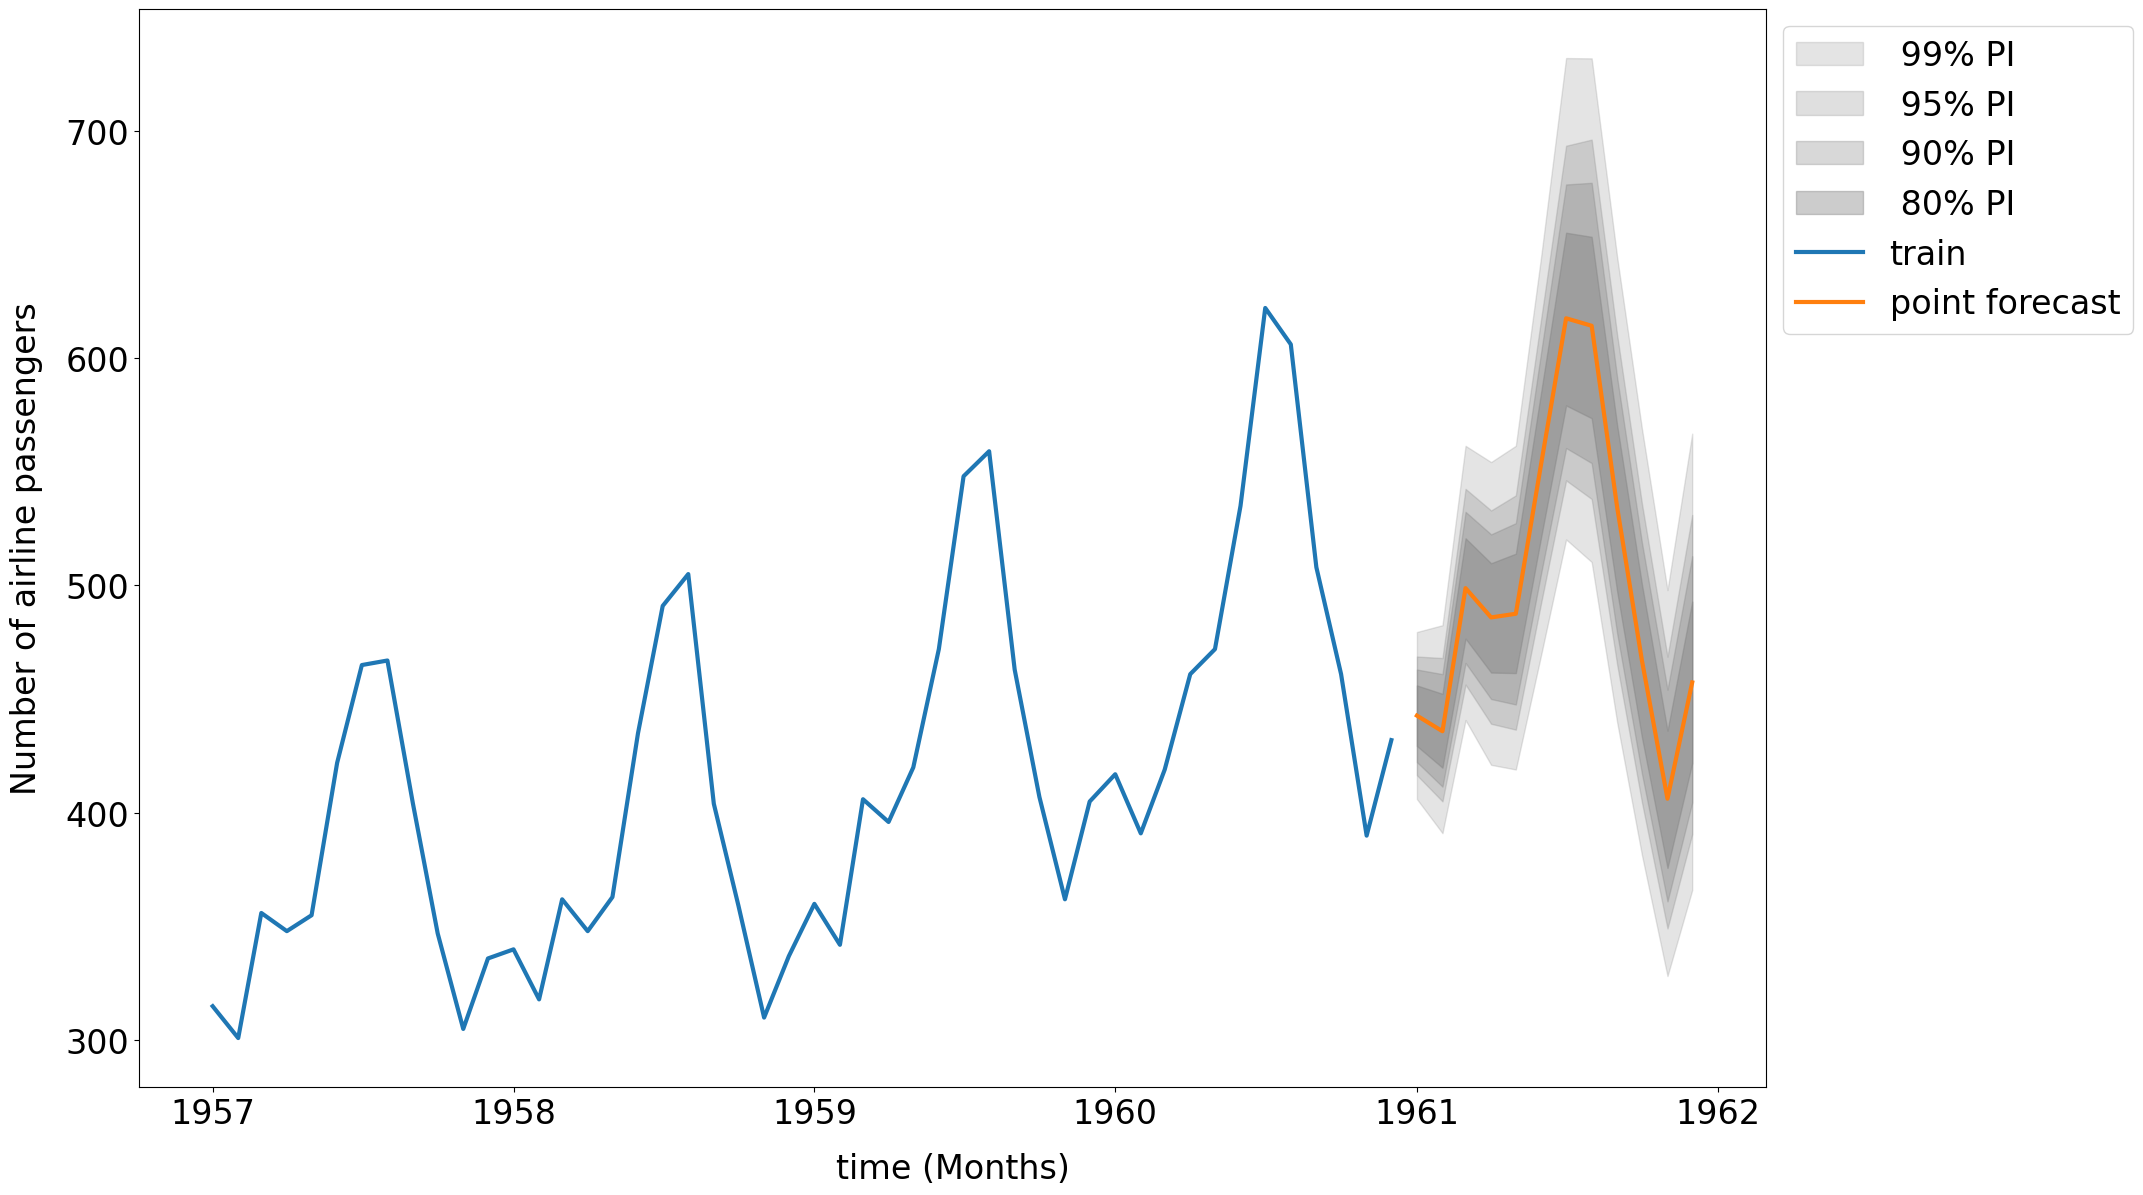

In [3]:
def plot_prediction_intervals_from_simulations(
    y_train,
    simulations,
    intervals,
    y_test = None,
    point_pred = None,
    min_opacity=0.7,
    max_opacity=0.2,
    plot_mean=False,
    plot_median=False
):
    """Plots prediction intervals from statsmodels simulated forecasts"""
    # map the intervals to the corresponding enclosing quantiles
    d = {i: (1-i, i) for i in intervals}
    opacity_coef = lambda x: (
        2 * x * (max_opacity - min_opacity) - max_opacity + 2 * min_opacity
    )
    
    plt.figure()
    for key, val in d.items():
        upper = simulations.quantile(val[0], axis=1)
        lower = simulations.quantile(val[1], axis=1)
        plt.fill_between(
            lower.index,
            lower,
            upper,
            color="grey",
            alpha=opacity_coef(key),
            label=f"{100*key: 0.0f}% PI",
        )
    
    plt.plot(y_train, label="train")
    if y_test is not None:
        plt.plot(y_test,label="test")
    if plot_median:
        plt.plot(simulations.median(axis=1), label="prediction median")
    if plot_mean:
        plt.plot(simulations.mean(axis=1), label="prediction mean")
    if point_pred is not None:
        plt.plot(point_pred, label="point forecast")
    
    plt.xlabel(f"time (Months)")
    plt.ylabel(y.name)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# example data 
y = load_airline(return_array=False)
y.index = y.index.to_timestamp()    
    
model = ETSModel(
    endog=y, 
    seasonal_periods=12, 
    error="mul", 
    seasonal="mul", 
    trend="add",
)
results = model.fit(disp=0)
sims = results.simulate(
    nsimulations=12, 
    repetitions=10000, 
    anchor="end", 
    random_state=42
)
point_pred = results.forecast(12)
plot_prediction_intervals_from_simulations(
    y.iloc[-48:], sims, [0.99, 0.95, 0.9, 0.8], point_pred=point_pred
)
plt.show()

## Point forecasts

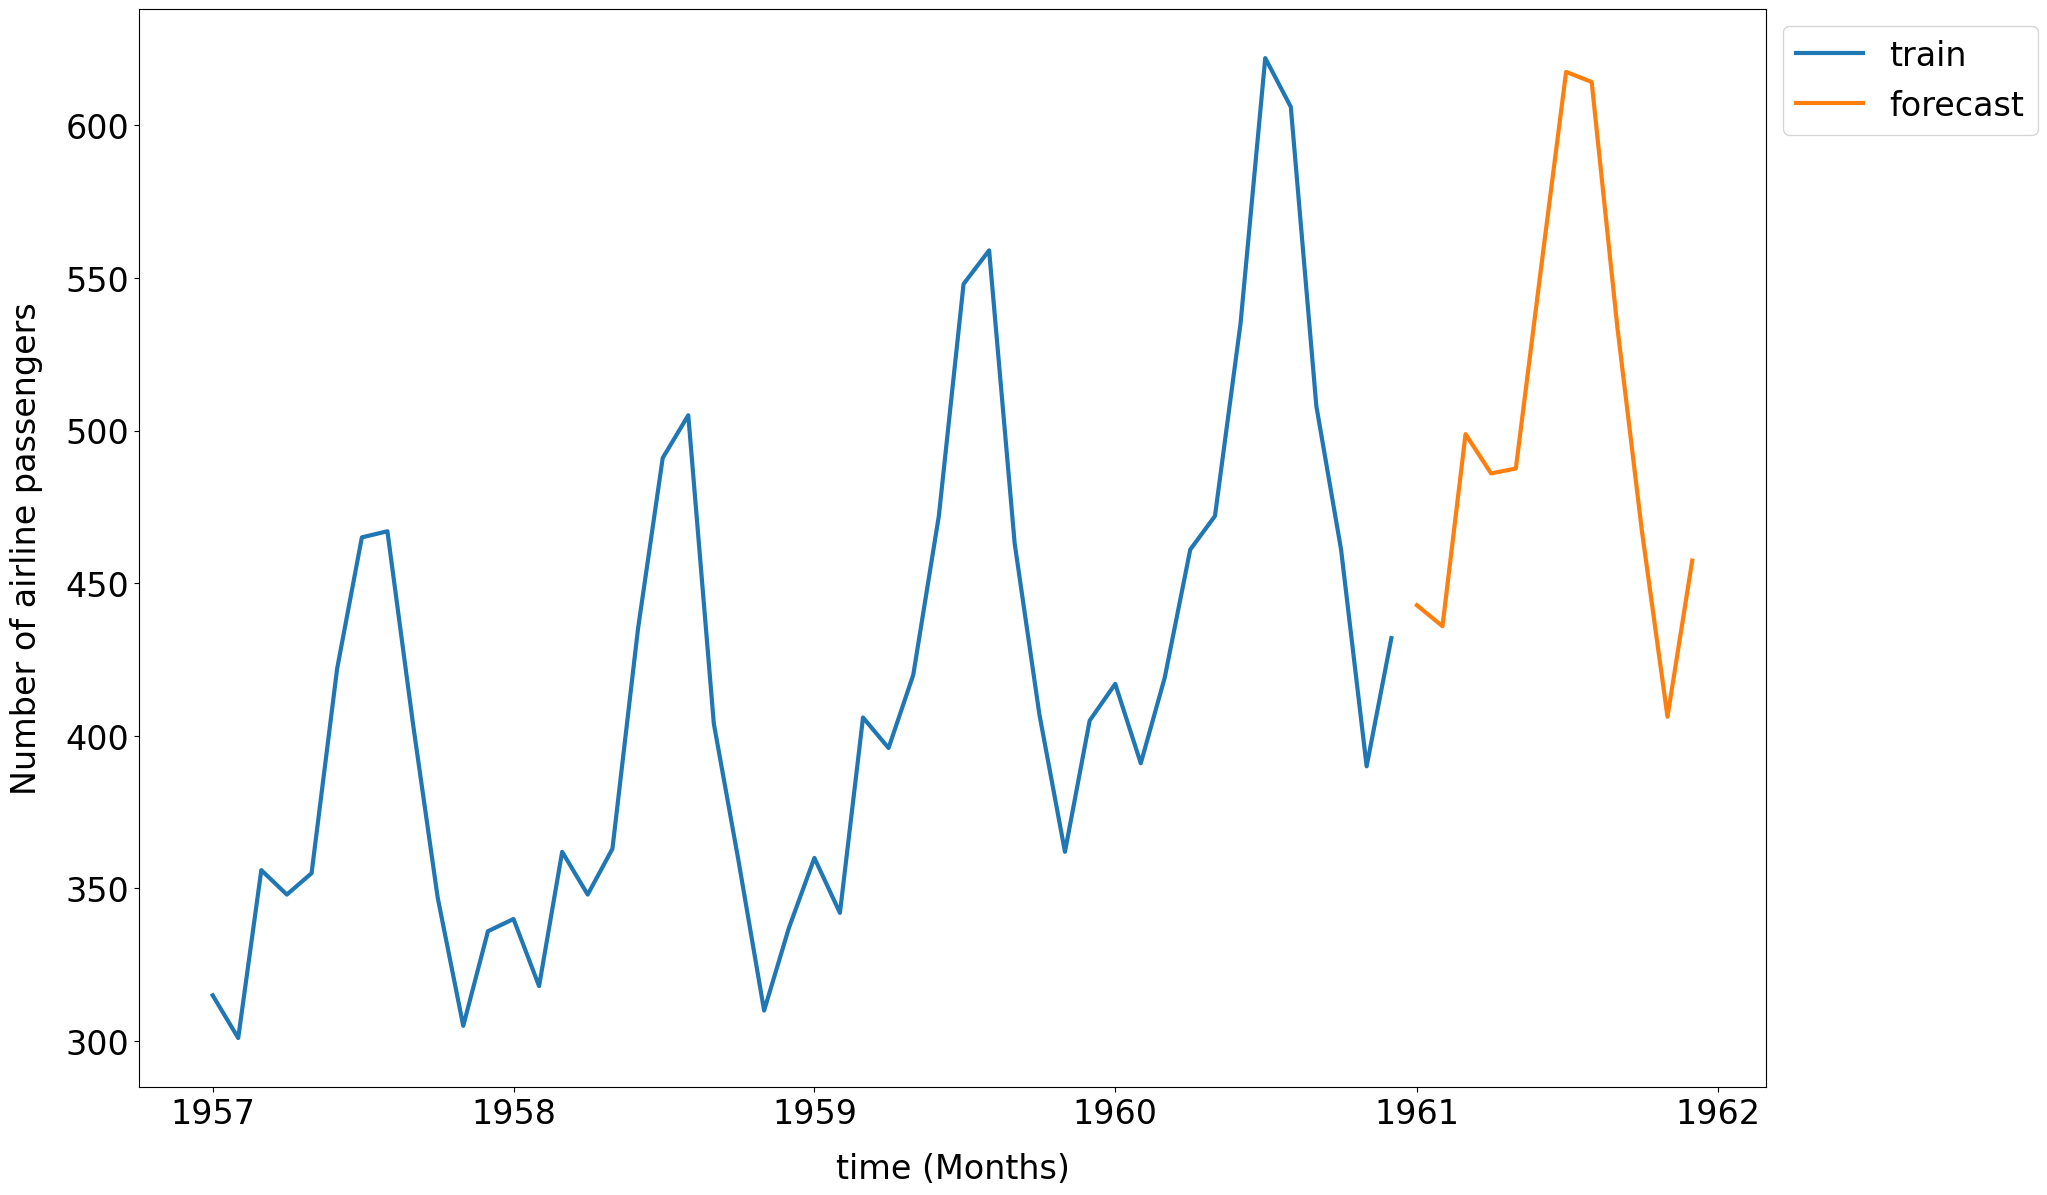

In [4]:
model = ETSModel(
    endog=y, 
    seasonal_periods=12, 
    error="mul", 
    seasonal="mul", 
    trend="add",
)
results = model.fit(disp=0)
point_fcast = results.forecast(12)
plt.plot(y.iloc[-48:], label="train")
plt.plot(point_fcast, label="forecast")
plt.xlabel(f"time (Months)")
plt.ylabel(y.name)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### CV example

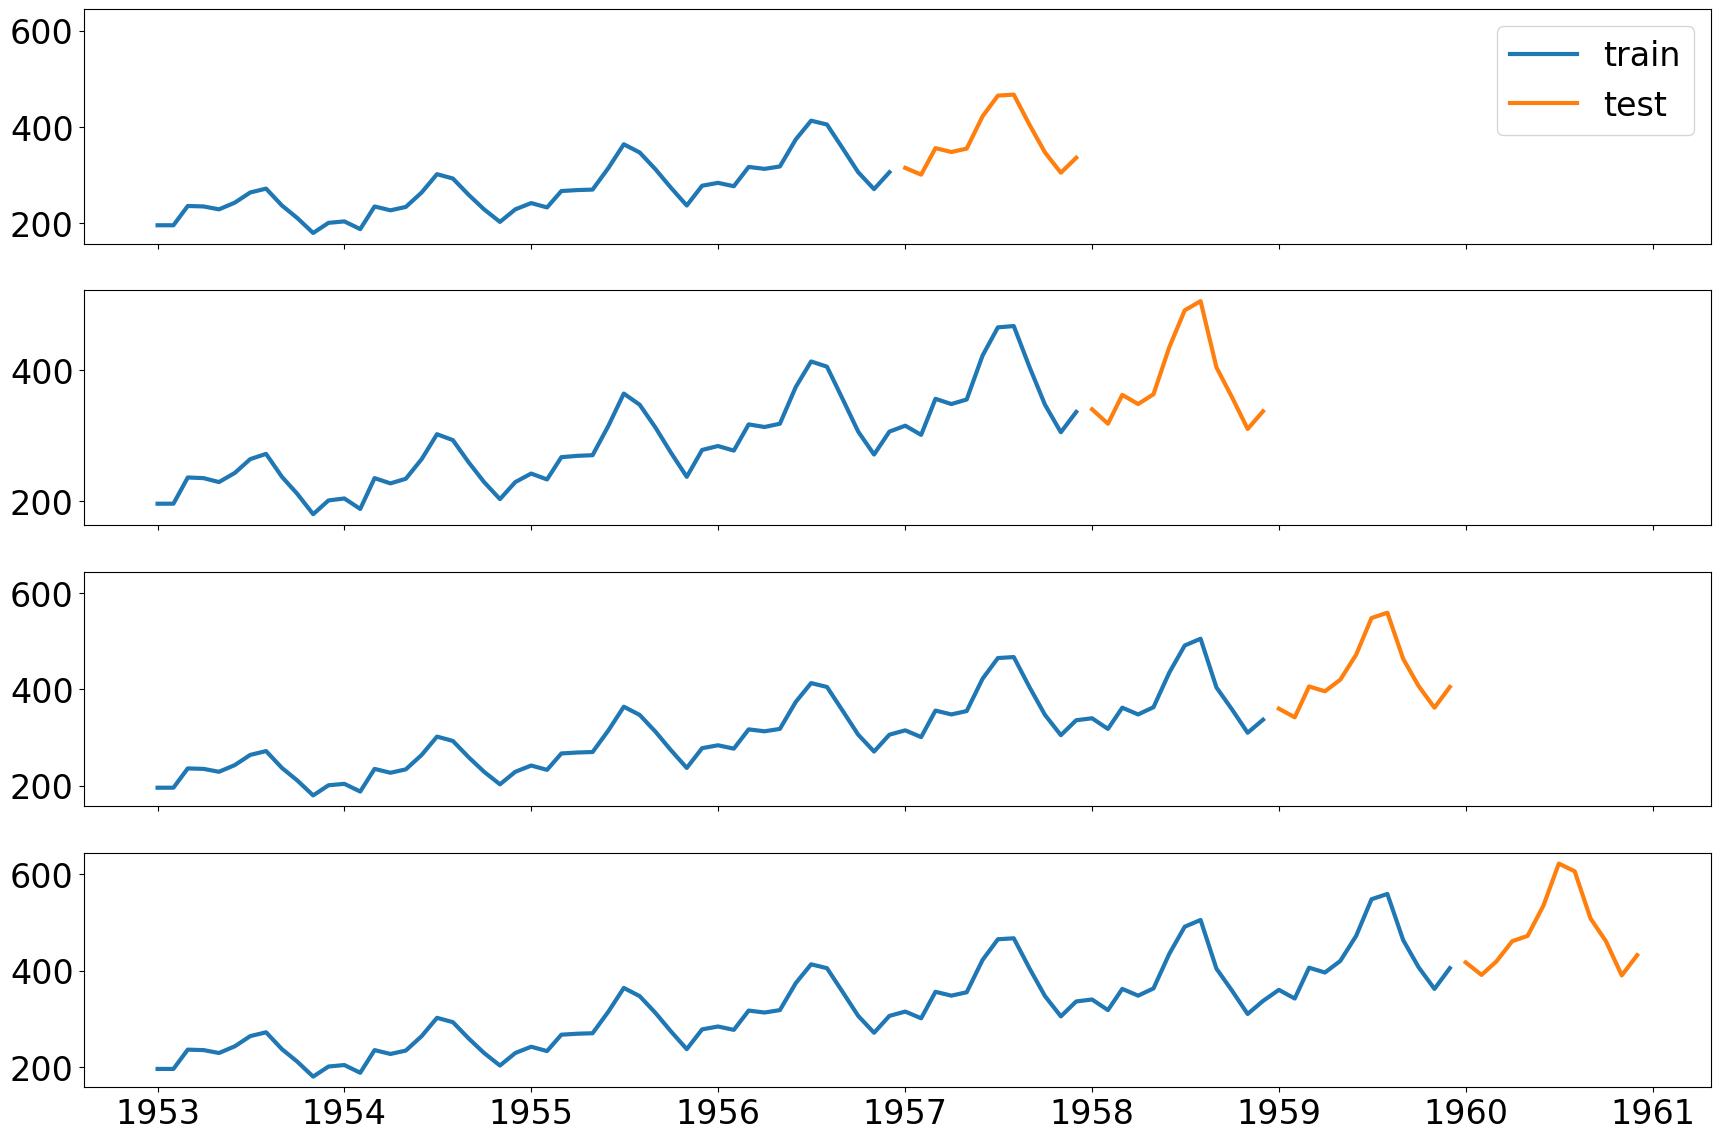

In [6]:
y = load_airline(return_array=False)
y.index = y.index.to_timestamp()
bottom_lim = -96

ax1 = plt.subplot(411)
# plot_series(y.iloc[:-48], y.iloc[-48:-36])
plt.plot(y.iloc[bottom_lim:-48], label="train")
plt.plot(y.iloc[-48:-36], label="test")
plt.tick_params('x', labelbottom=False)

# share x only
ax2 = plt.subplot(412, sharex=ax1)
# make these tick labels invisible
plt.plot(y.iloc[bottom_lim:-36], label="train")
plt.plot(y.iloc[-36:-24], label="test")
plt.tick_params('x', labelbottom=False)

# share x and y
ax3 = plt.subplot(413, sharex=ax1, sharey=ax1)
plt.plot(y.iloc[bottom_lim:-24], label="train")
plt.plot(y.iloc[-24:-12], label="test")
plt.tick_params('x', labelbottom=False)

ax4 = plt.subplot(414, sharex=ax1, sharey=ax1)
plt.plot(y.iloc[bottom_lim:-12], label="train")
plt.plot(y.iloc[-12:], label="test")

ax1.legend()
plt.show()

# Point Forecasting metrics

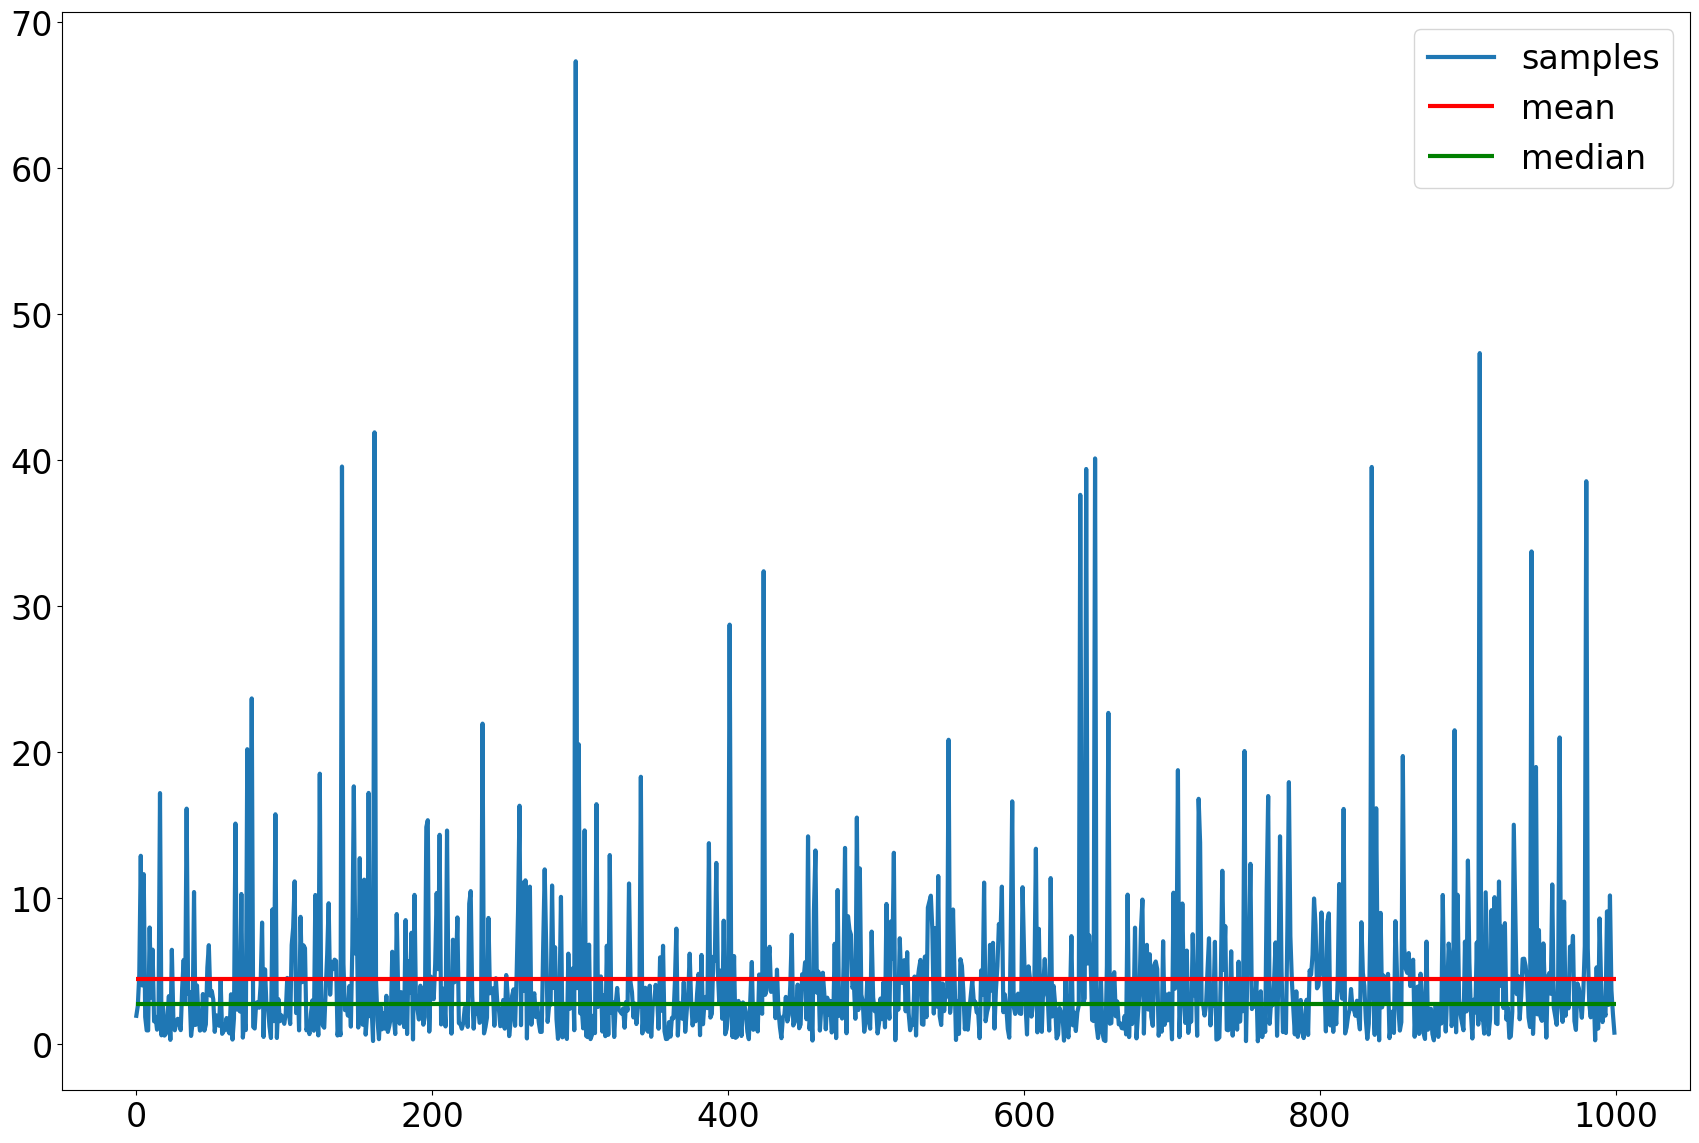

In [7]:
rng = np.random.default_rng()

# lognormal stats functions:
lognormal_mean = lambda m, s: np.exp(m+((s**2)/2))
lognormal_median = lambda m: np.exp(m)

m = 1
s = 1
num_samples = 1000
synthetic_ts = rng.lognormal(m, s, num_samples).reshape(-1, 1)

plt.plot(synthetic_ts, label="samples")
plt.hlines(lognormal_mean(m, s), 0, num_samples, color="r", label="mean")
plt.hlines(lognormal_median(m), 0, num_samples, color="g", label="median")
plt.legend()
plt.show()

In [8]:
# Error metrics
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred), axis=1)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2, axis=1))

def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)/y_true, axis=1)

def minmax_scale(y):
    return (y - np.min(y)) / (np.max(y)-np.min(y))

In [9]:
max_x = 10
min_x = 0
prediction_grid = np.arange(min_x, max_x, step=0.001).reshape(-1, 1)
rmse_prediction_grid = minmax_scale(rmse(synthetic_ts.T, prediction_grid))
mae_prediction_grid = minmax_scale(mae(synthetic_ts.T, prediction_grid))
mape_prediction_grid = minmax_scale(mape(synthetic_ts.T, prediction_grid))

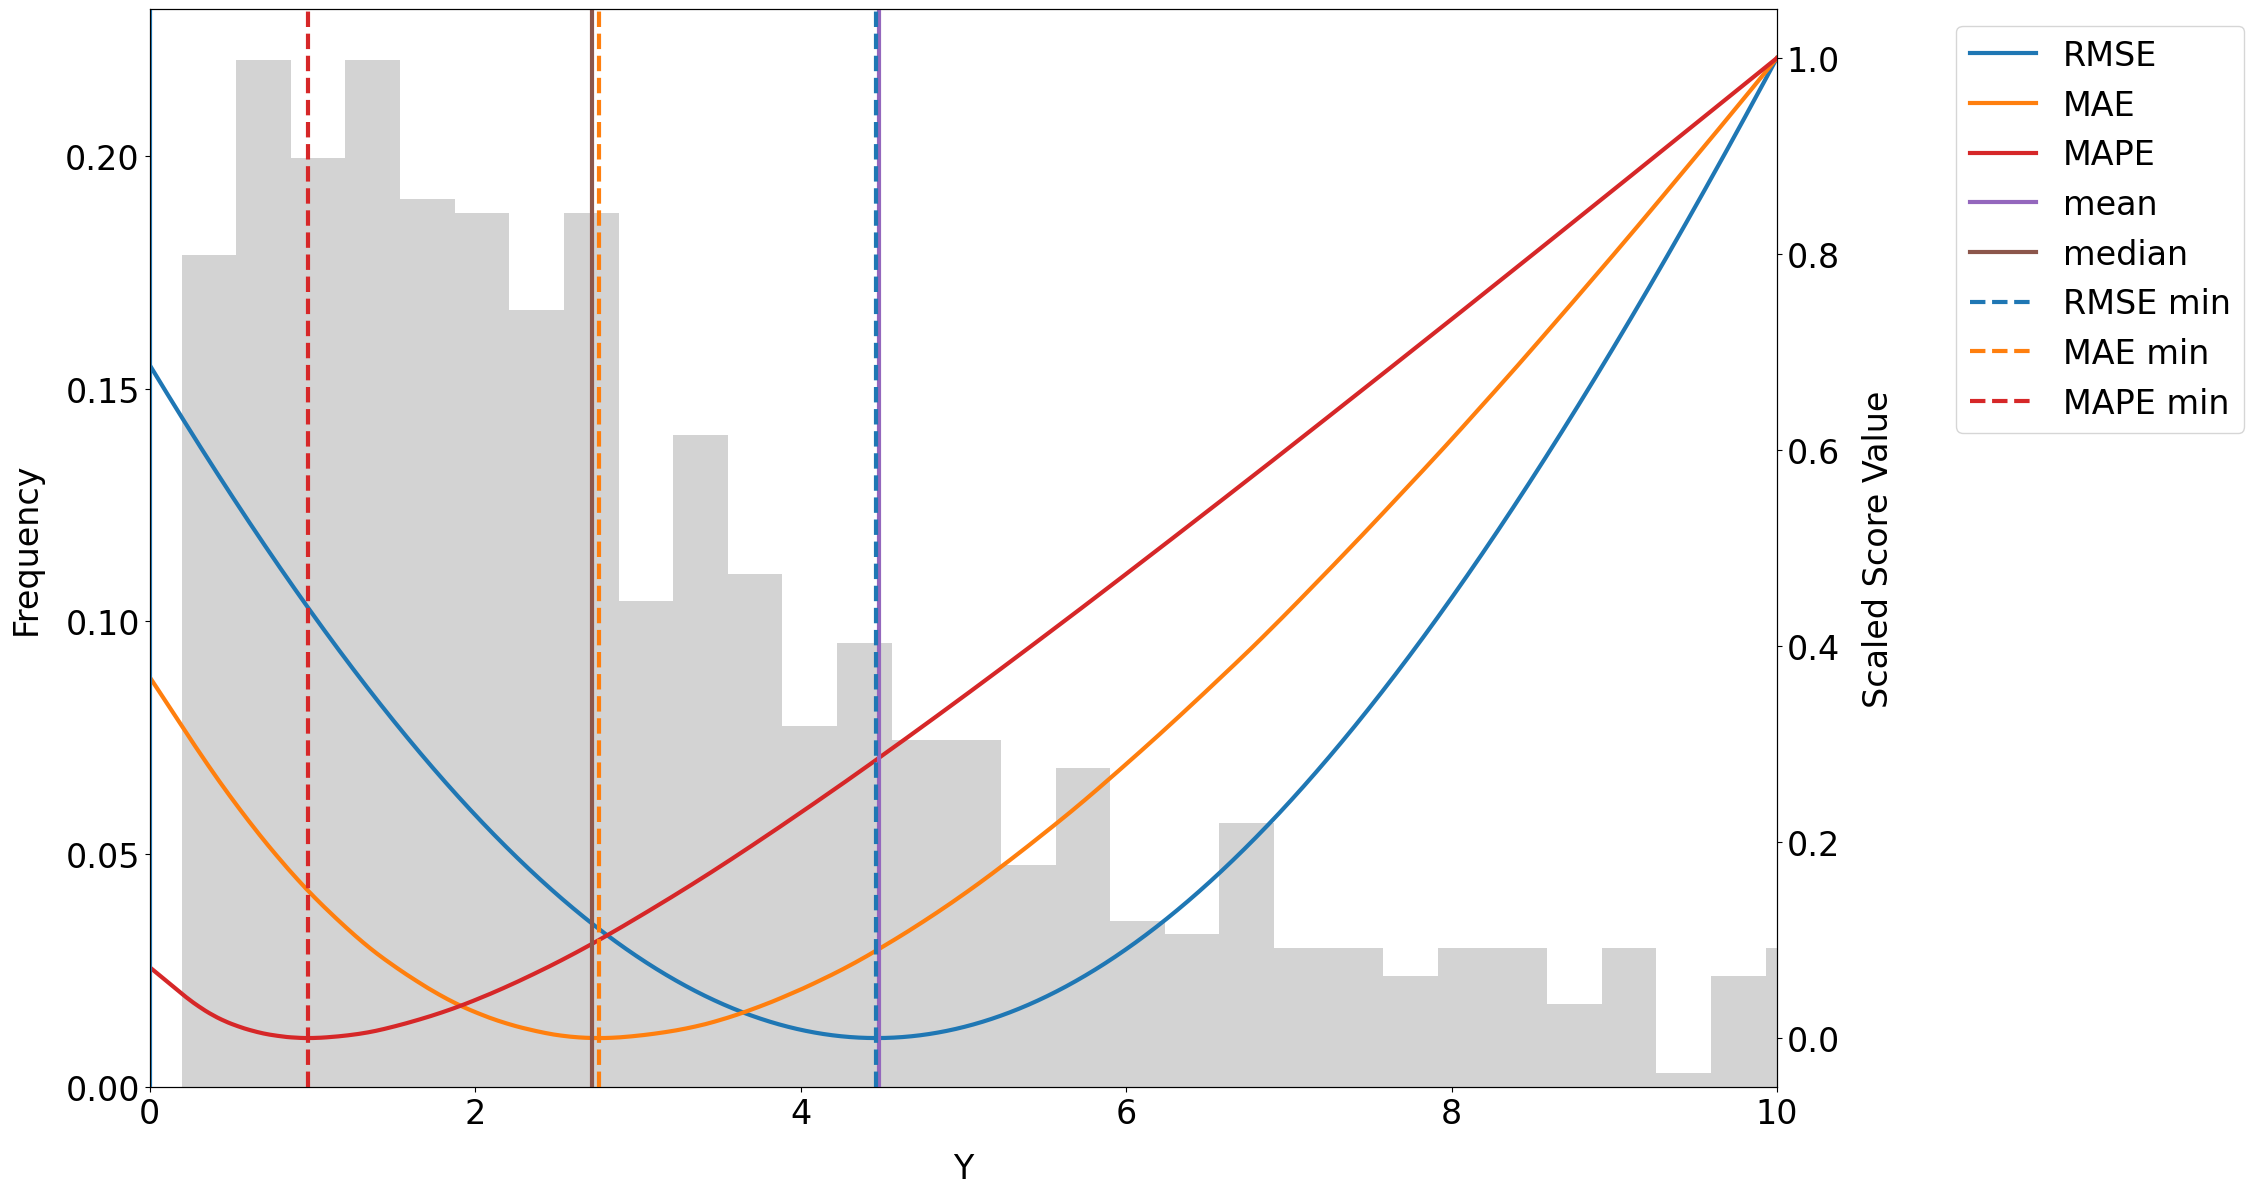

In [10]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

# plt.title(f"Metrics Comparison")
ax2.set_ylabel("Scaled Score Value")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Y")

ax1.hist(synthetic_ts, bins=200, density=True, color="lightgrey")
ax2.plot(prediction_grid, rmse_prediction_grid, label="RMSE", color="C0")
ax2.plot(prediction_grid, mae_prediction_grid, label="MAE", color="C1")
ax2.plot(prediction_grid, mape_prediction_grid, label="MAPE", color="C3")
ax2.axvline(lognormal_mean(m, s), label="mean", color="C4")
ax2.axvline(lognormal_median(m), label="median", color="C5")
ax2.axvline()
ax2.axvline(
    prediction_grid[np.argmin(rmse_prediction_grid)], 
    color="C0", 
    linestyle="dashed", 
    label="RMSE min"
)
ax2.axvline(
    prediction_grid[np.argmin(mae_prediction_grid)], 
    color="C1", 
    linestyle="dashed", 
    label="MAE min"
)
ax2.axvline(
    prediction_grid[np.argmin(mape_prediction_grid)], 
    color="C3", 
    linestyle="dashed", 
    label="MAPE min"
)
plt.xlim(min_x, max_x)
ax2.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
plt.show()

# Distribution with Observation

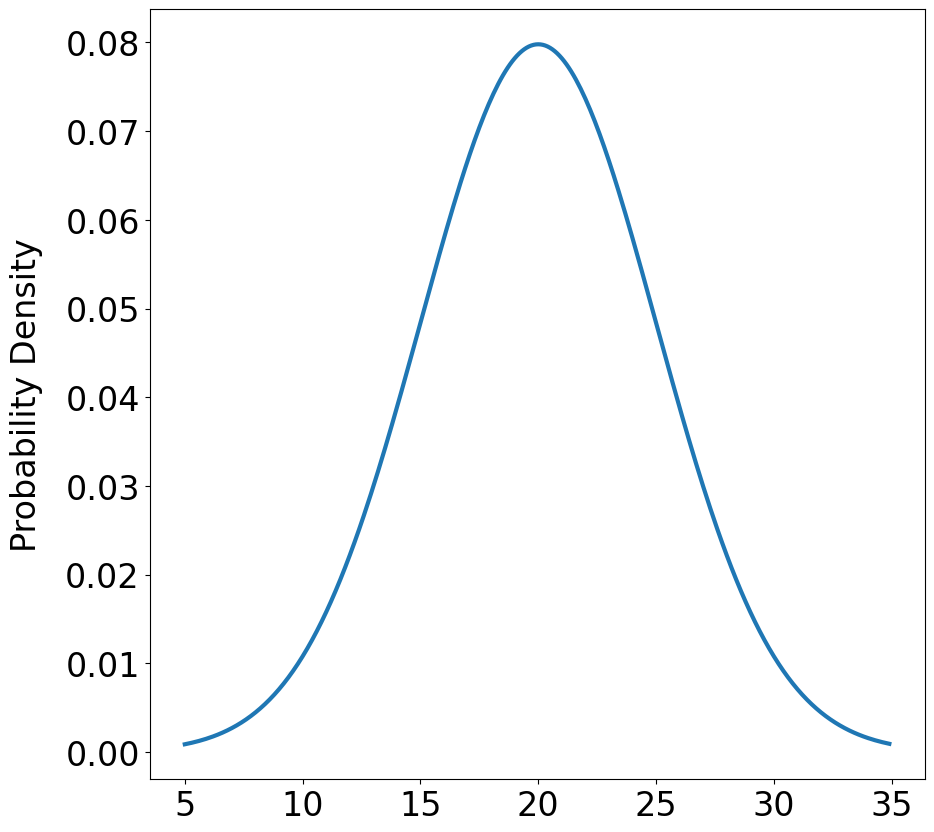

In [11]:
normal_dist = norm(20, 5)
x_axis = np.arange(5, 35, step=0.1)

plt.figure(figsize=(10, 10))
plt.plot(x_axis, normal_dist.pdf(x_axis), label="forecast distribution")
plt.ylabel("Probability Density")
plt.show()

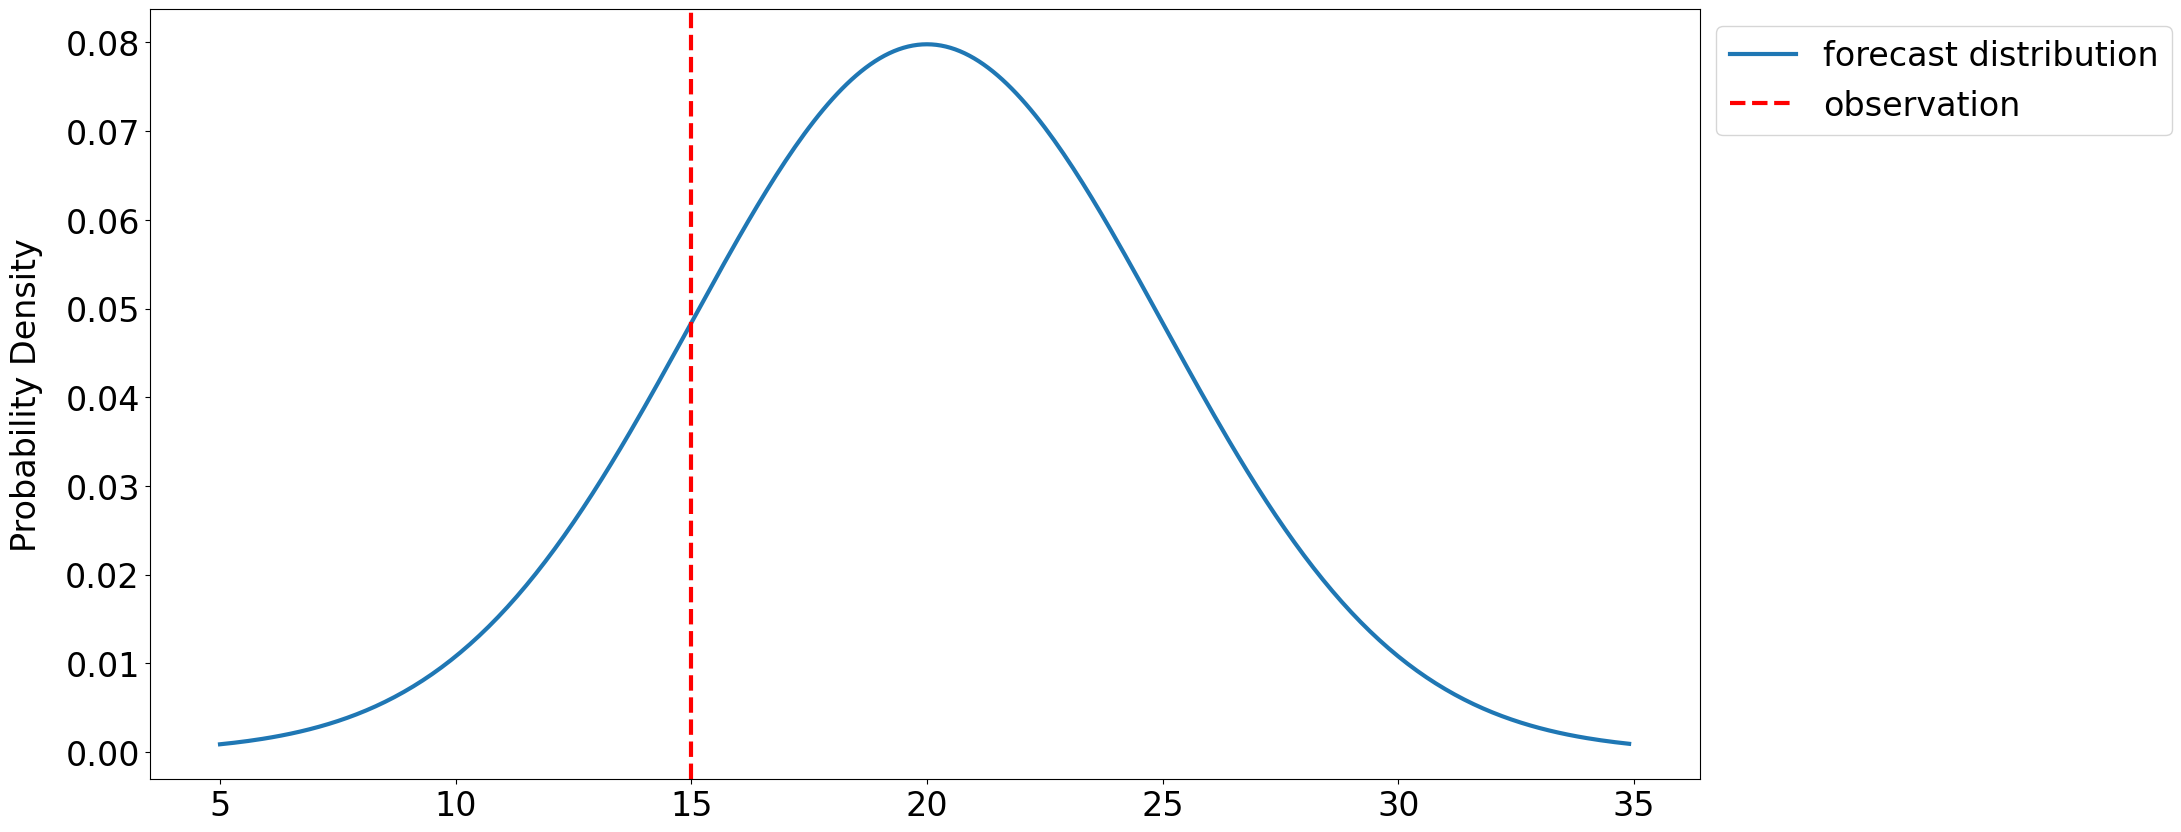

In [12]:
normal_dist = norm(20, 5)
x_axis = np.arange(5, 35, step=0.1)

plt.figure(figsize=(20, 10))
plt.plot(x_axis, normal_dist.pdf(x_axis), label="forecast distribution")
plt.axvline(15, label="observation", color="red", linestyle="--")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Probability Density")
plt.show()

# Samples and Distributions

In [13]:
# "Actuals" parameters
min_pred = 0
max_pred = 210
actuals = np.arange(min_pred, max_pred, step=1)
N = len(actuals)

# dist paramenters
r = 3600/900
p = 60/900

# scipy dist
frozen_dist = nbinom(r, p)
dist_list = [deepcopy(frozen_dist) for _ in range(N)]

#samples
rng = np.random.default_rng(42)
samples_single = rng.negative_binomial(r, p, 1000000)
samples = np.tile(samples_single, (N, 1))

# Log Score

### Scipy distribution

In [14]:
def scipy_dist_log_score(
    dist_list: List[rv_frozen],
    actuals: np.array,
) -> np.array:
    """Log Score, -log(P(y)) for scipy distributions
    
    Args:
        dist_list (List[rv_frozen]): list of scipy frozen distributions for each
            time step
        actuals (np.array): 1d array of the actual values
    
    Returns:
        np.array: Log Score vector, -log(P(y)) to satisfy the convention smaller is
            better
    
    Notes: 
        This function only works with scipy>=1.9 (fails with 1.7)
    """
    probs = [
        dist_list[i].pmf(actuals[i])
        if hasattr(dist_list[i], "pmf")
        else dist_list[i].pdf(actuals[i])
        for i in range(len(dist_list))
    ]
    return -np.log(probs)

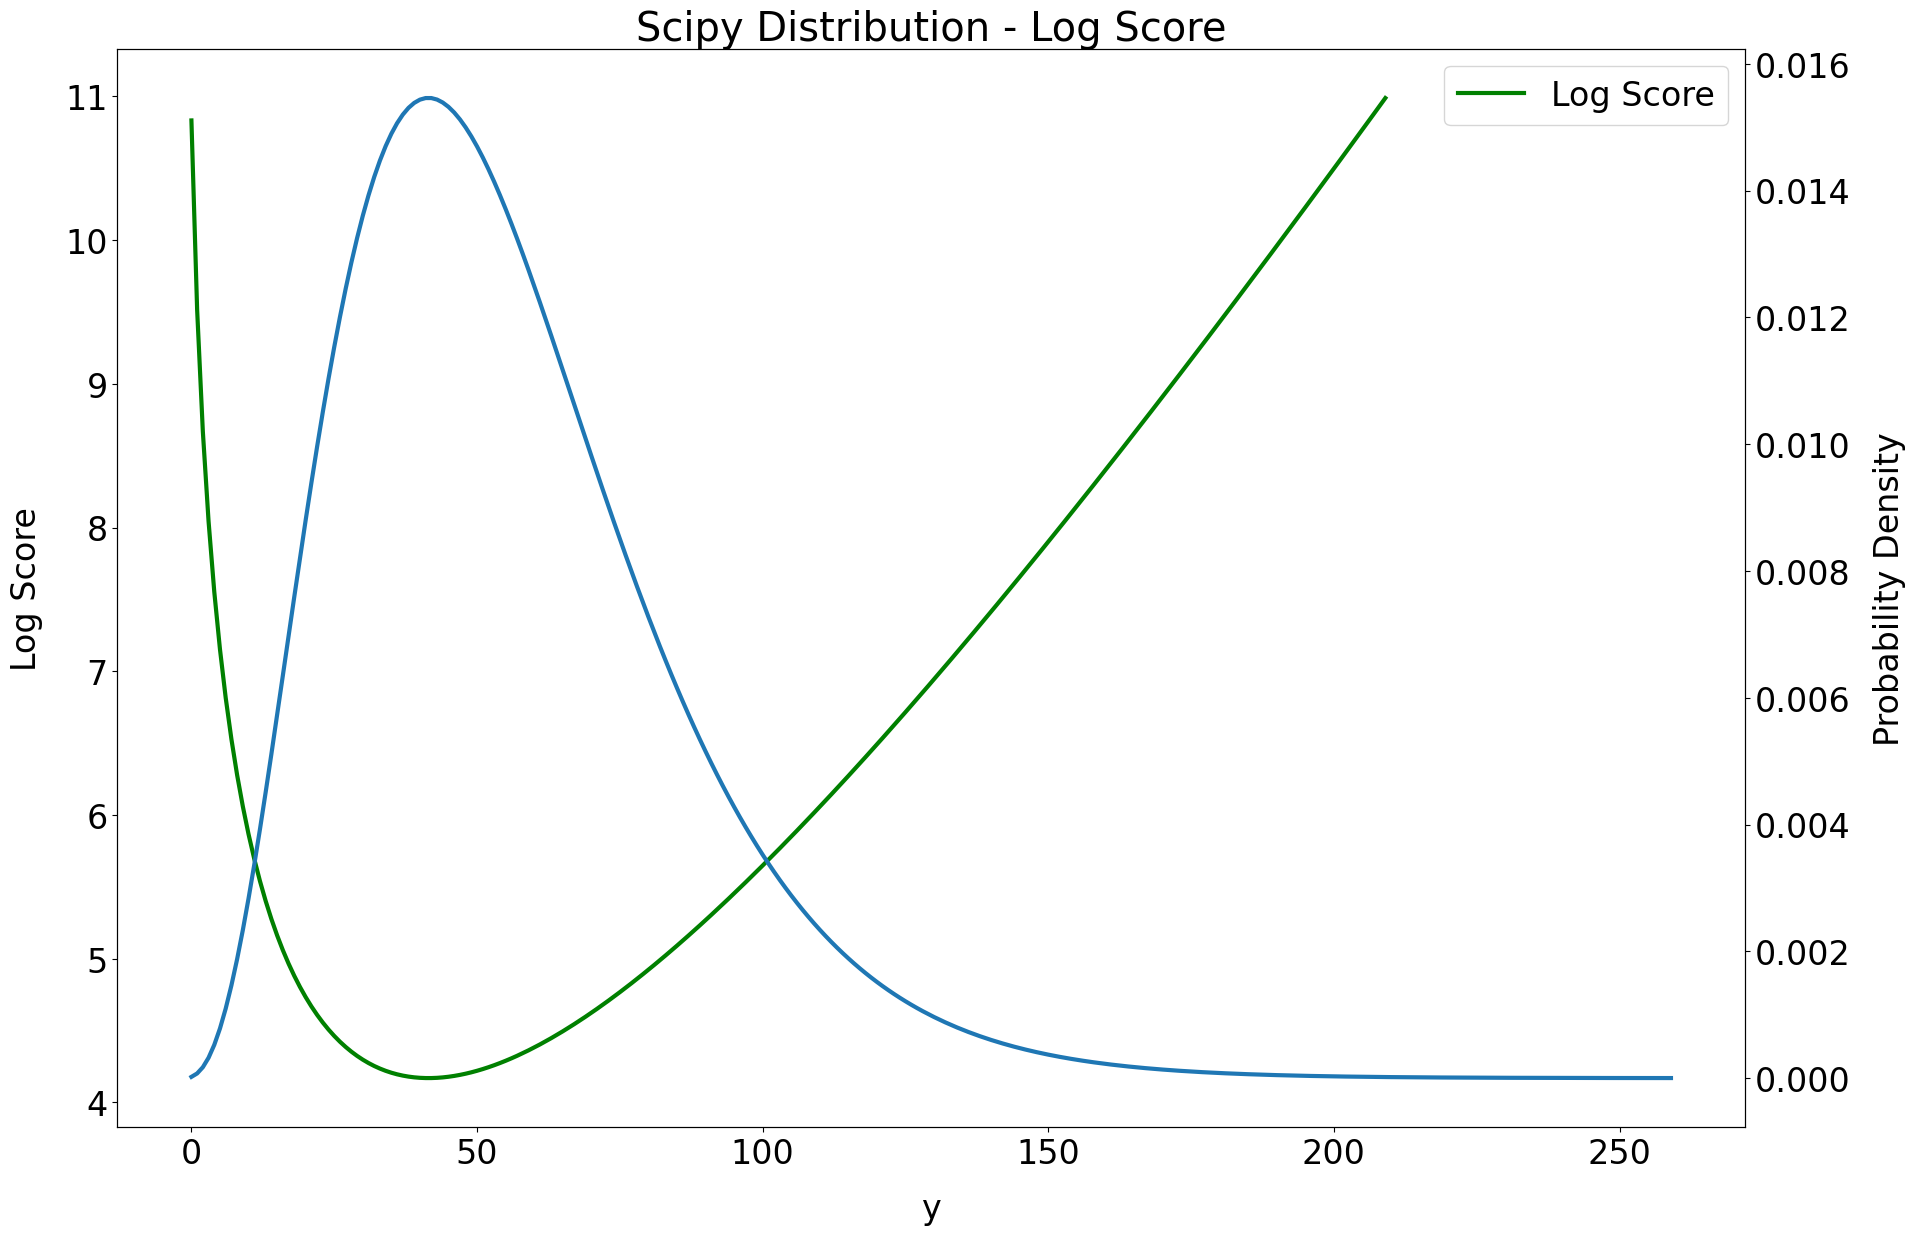

In [15]:
log_score = scipy_dist_log_score(dist_list, actuals)

fig, ax1 = plt.subplots()

min_lim = 0
max_lim = 260
x_axis = np.arange(min_lim, max_lim, step=1)

ax2 = ax1.twinx()
ax2.plot(x_axis, frozen_dist.pmf(x_axis), label='Distribution PDF')
ax1.plot(actuals, log_score, color="g", label="Log Score")

plt.title(f"Scipy Distribution - Log Score")
ax2.set_ylabel("Probability Density")
ax1.set_ylabel("Log Score")
ax1.set_xlabel("y")

ax1.legend()
plt.show()

### Samples

In [16]:
def sample_log_score(
    samples: np.array, actuals: np.array, n_bins: int = 50
) -> np.array:
    """Log Score, -log(P(y)) for samples
    
    Args:
        samples (np.array): 2d array of sampled paths. 1st dim is time, 2nd dim is
            number of samples
        actuals (np.array): 1d array of the actual values
        n_bins (int, optional): number of bins used to create the histogram from
            the samples, by default 50
        
    Returns:
        np.array: Log Score vector, -log(P(y)) to satisfy the convention smaller is 
            better
    """
    hist = [
        np.histogram(samples[i], bins=n_bins, density=True)
        for i in range(samples.shape[0])
    ]

    probs = [hist[i][0][np.digitize(actuals[i], hist[i][1])] for i in range(len(hist))]

    return -np.log(probs)

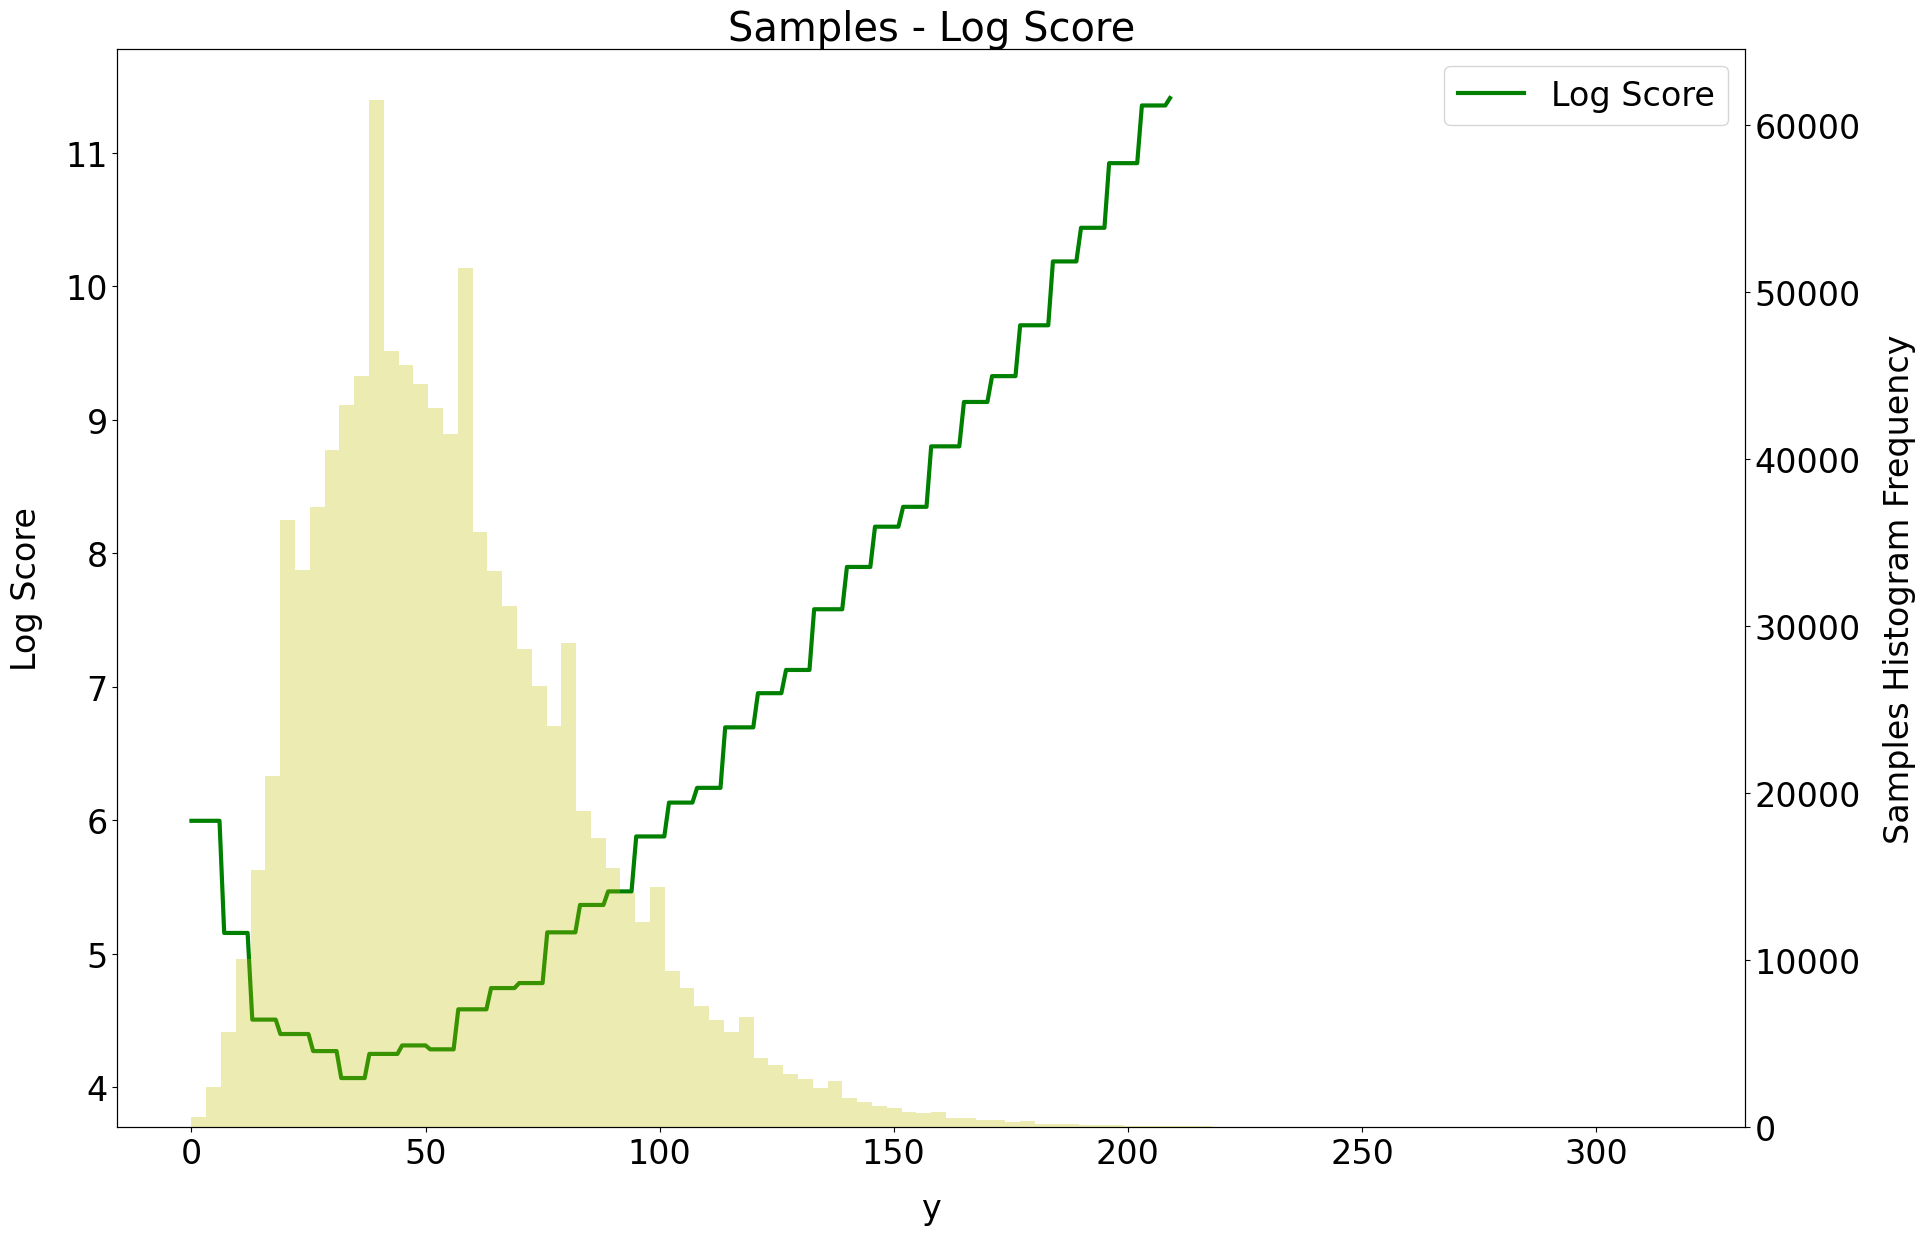

In [17]:
log_score = sample_log_score(samples, actuals)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.hist(
    samples_single, 
    bins=100, 
    edgecolor='None', 
    alpha = 0.3, 
    color= 'y', 
    label="Samples Histogram"
)
ax1.plot(actuals, log_score , color="g", label="Log Score")

plt.title(f"Samples - Log Score")
ax2.set_ylabel("Samples Histogram Frequency")
ax1.set_ylabel("Log Score")
ax1.set_xlabel("y")
ax1.legend()
plt.show()

### Proper scoring property illustration

100%|██████████| 50/50 [06:36<00:00,  7.93s/it]


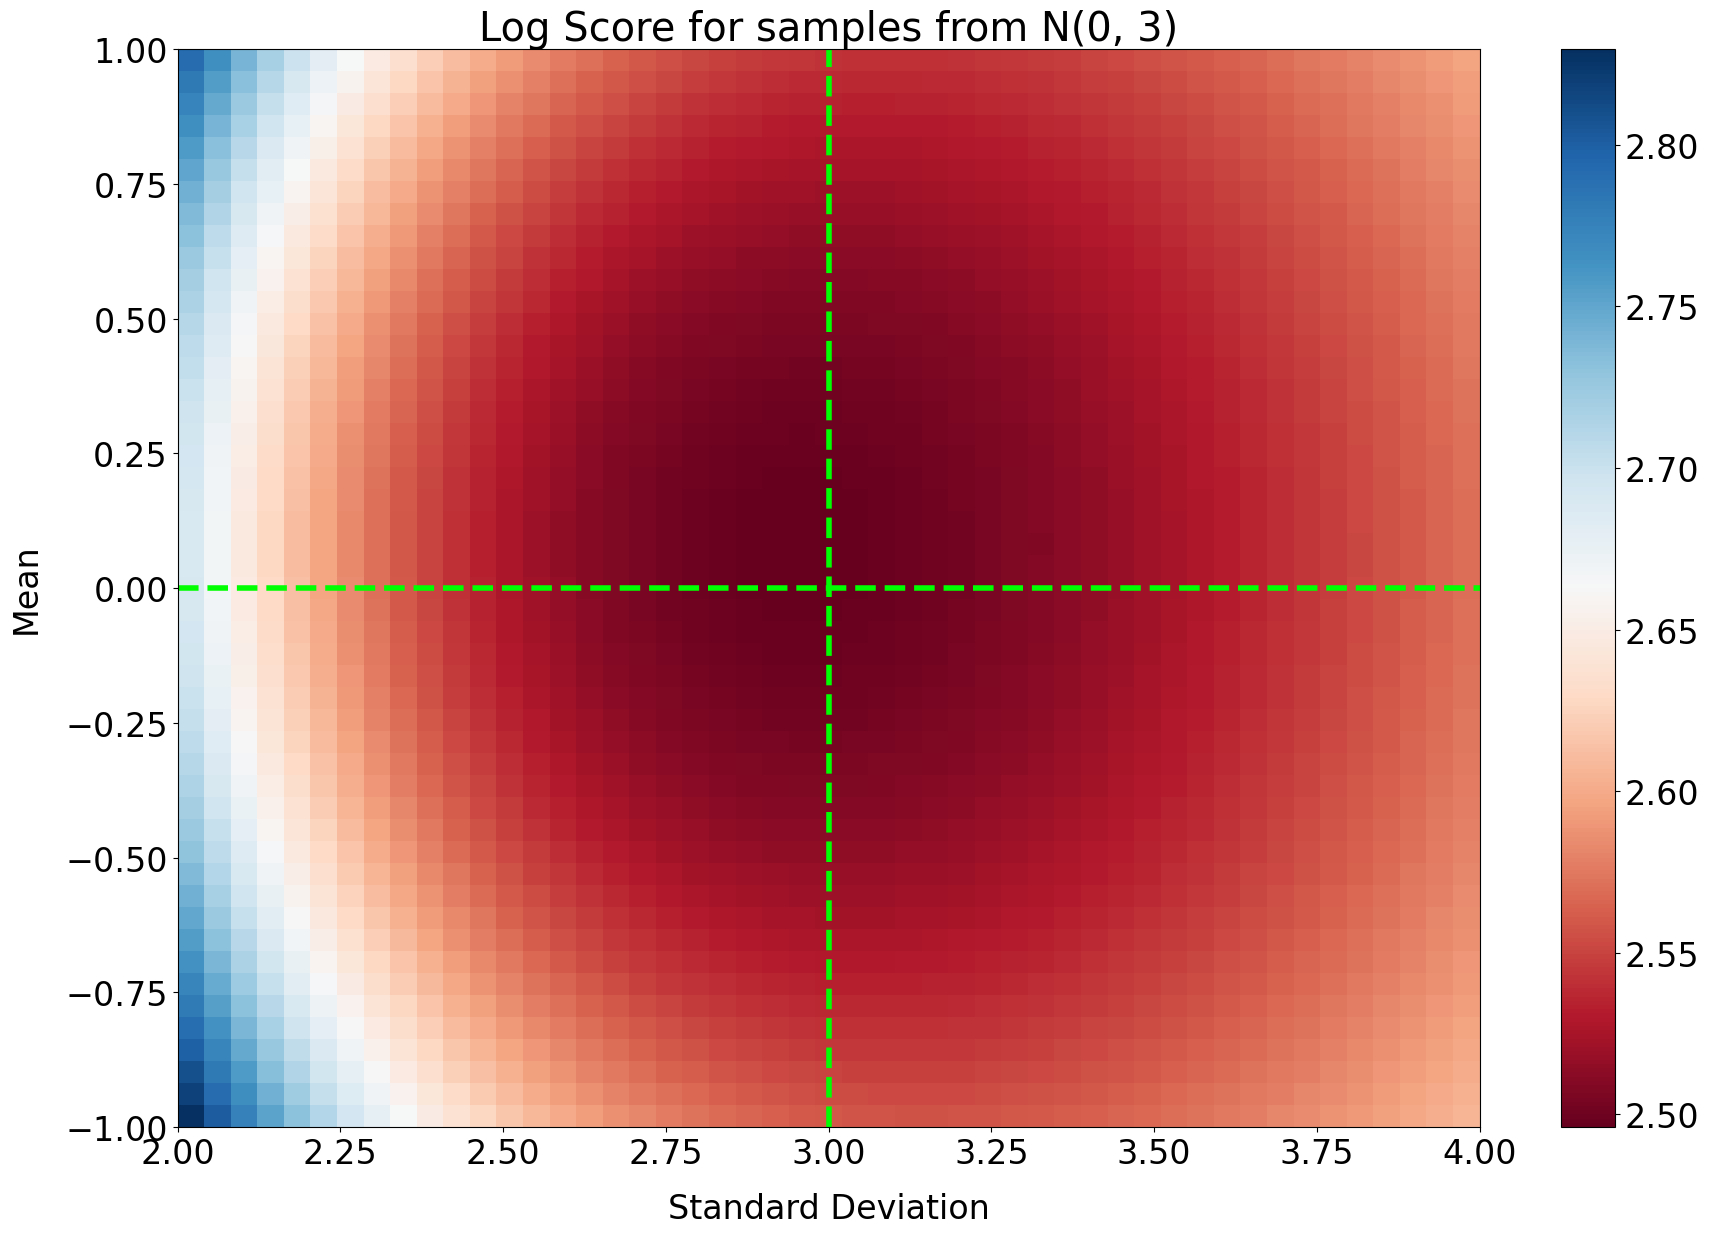

In [18]:
# Note: this code will take a while to run :(
data_gen_dist = norm(0, 3)
real_samples = data_gen_dist.rvs(size=1000, random_state=42)

N = 50
mu_space, sigma_space = y, x = np.meshgrid(np.linspace(-1, 1, N), np.linspace(2, 4, N))
log_score_matrix = np.empty((N, N))
for i in tqdm(range(N)):
    for j in range(N):
        mu = mu_space[i][j]
        sigma = sigma_space[i][j]
        tmp_dist_list = [norm(mu, sigma) for _ in range(len(real_samples))]
        score = scipy_dist_log_score(tmp_dist_list, real_samples)
        log_score_matrix[i ,j] = np.mean(score)


x = sigma_space
y = mu_space
z = log_score_matrix

# generate 2 2d grids for the x & y bounds
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Log Score for samples from N(0, 3)')
# set the limits of the plot to the limits of the data
ax.set_ylabel("Mean")
ax.set_xlabel("Standard Deviation")
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.vlines(3, -1, 1, linestyles="dashed", color="lime", linewidth=4)
ax.hlines(0, 2, 4, linestyles="dashed", color="lime", linewidth=4)
fig.colorbar(c, ax=ax)
plt.show()

# CRPS 

### CRPS areas illustrated

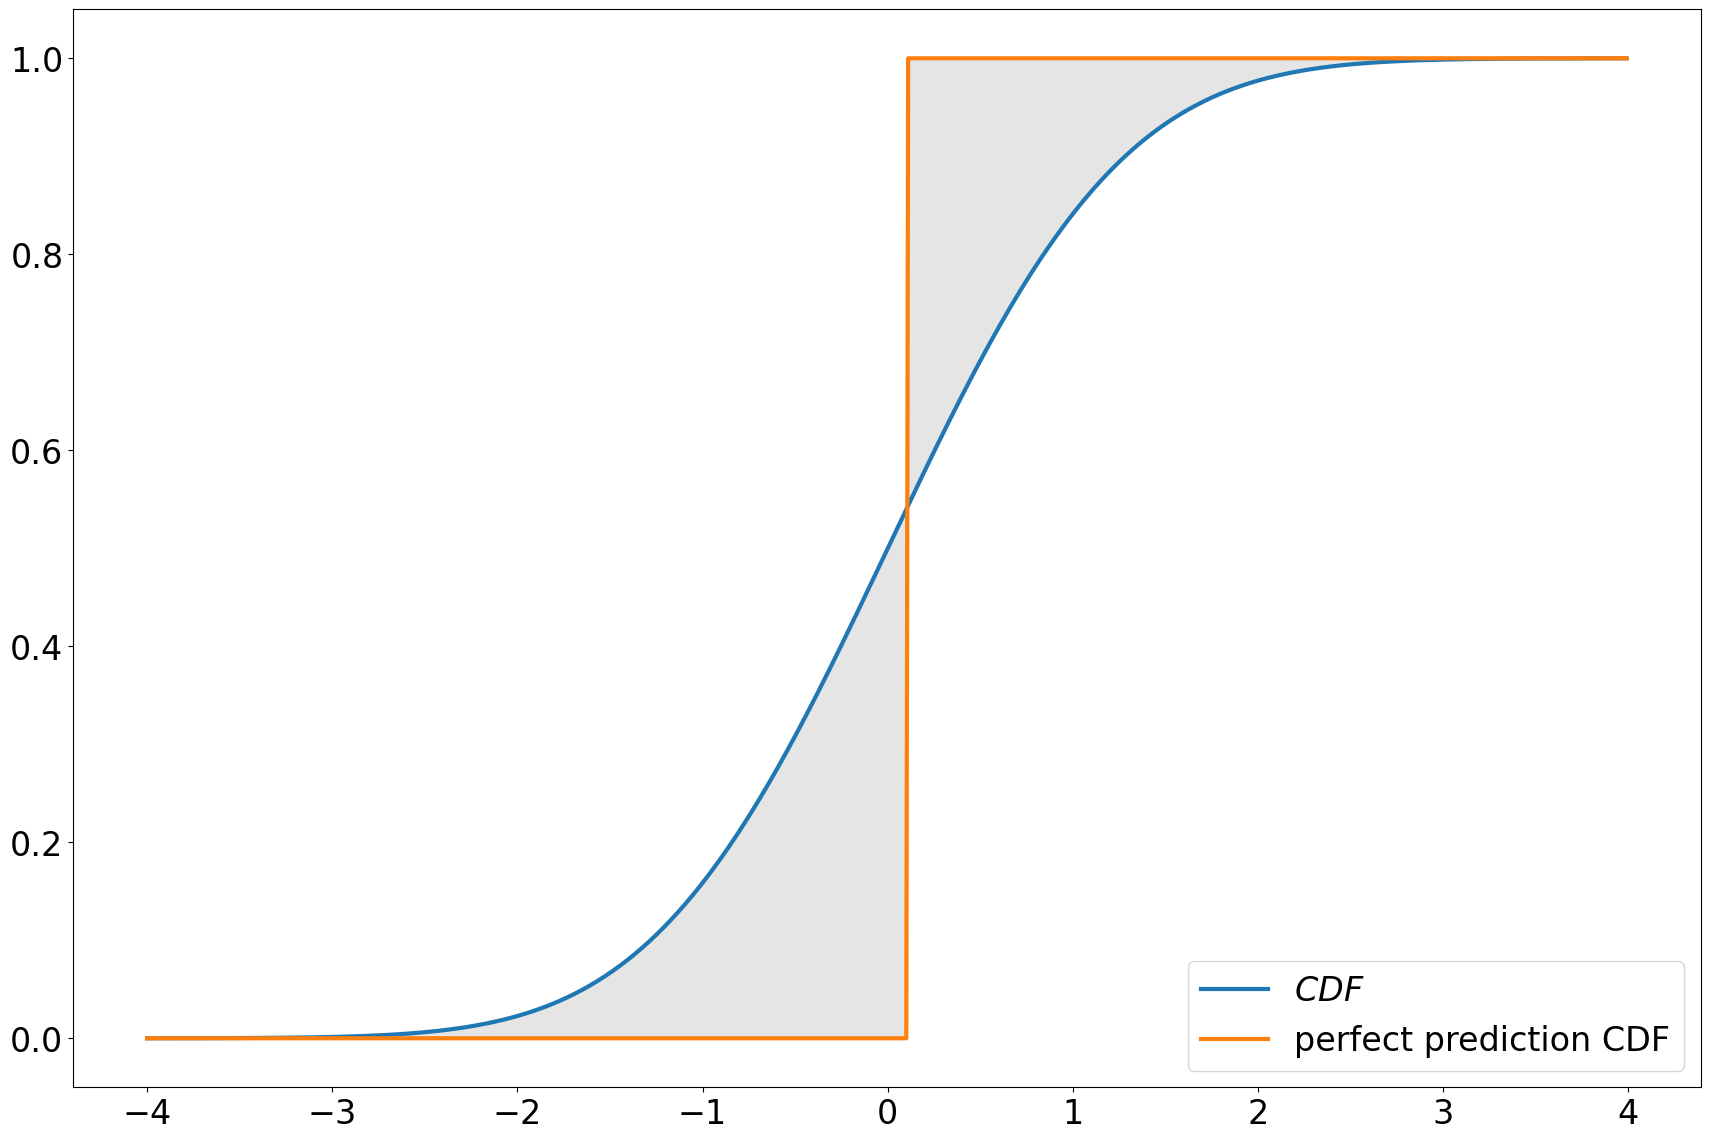

In [19]:
min_lim = -4
max_lim = 4
x_axis = np.arange(min_lim, max_lim, step=0.01)
dist = norm(0, 1)
perfect_pred = 1 * (x_axis > 0.1)

plt.plot(x_axis, dist.cdf(x_axis), label=r"$CDF$")
plt.plot(x_axis, perfect_pred, label="perfect prediction CDF")

plt.fill_between(
    x_axis,
    dist.cdf(x_axis),
    perfect_pred,
    where = dist.cdf(x_axis) < perfect_pred,
    color="grey",
    alpha=0.2
)

plt.fill_between(
    x_axis,
    dist.cdf(x_axis),
    perfect_pred,
    where = dist.cdf(x_axis) > perfect_pred,
    color="grey",
    alpha=0.2
)

plt.legend(loc="lower right")
plt.show()

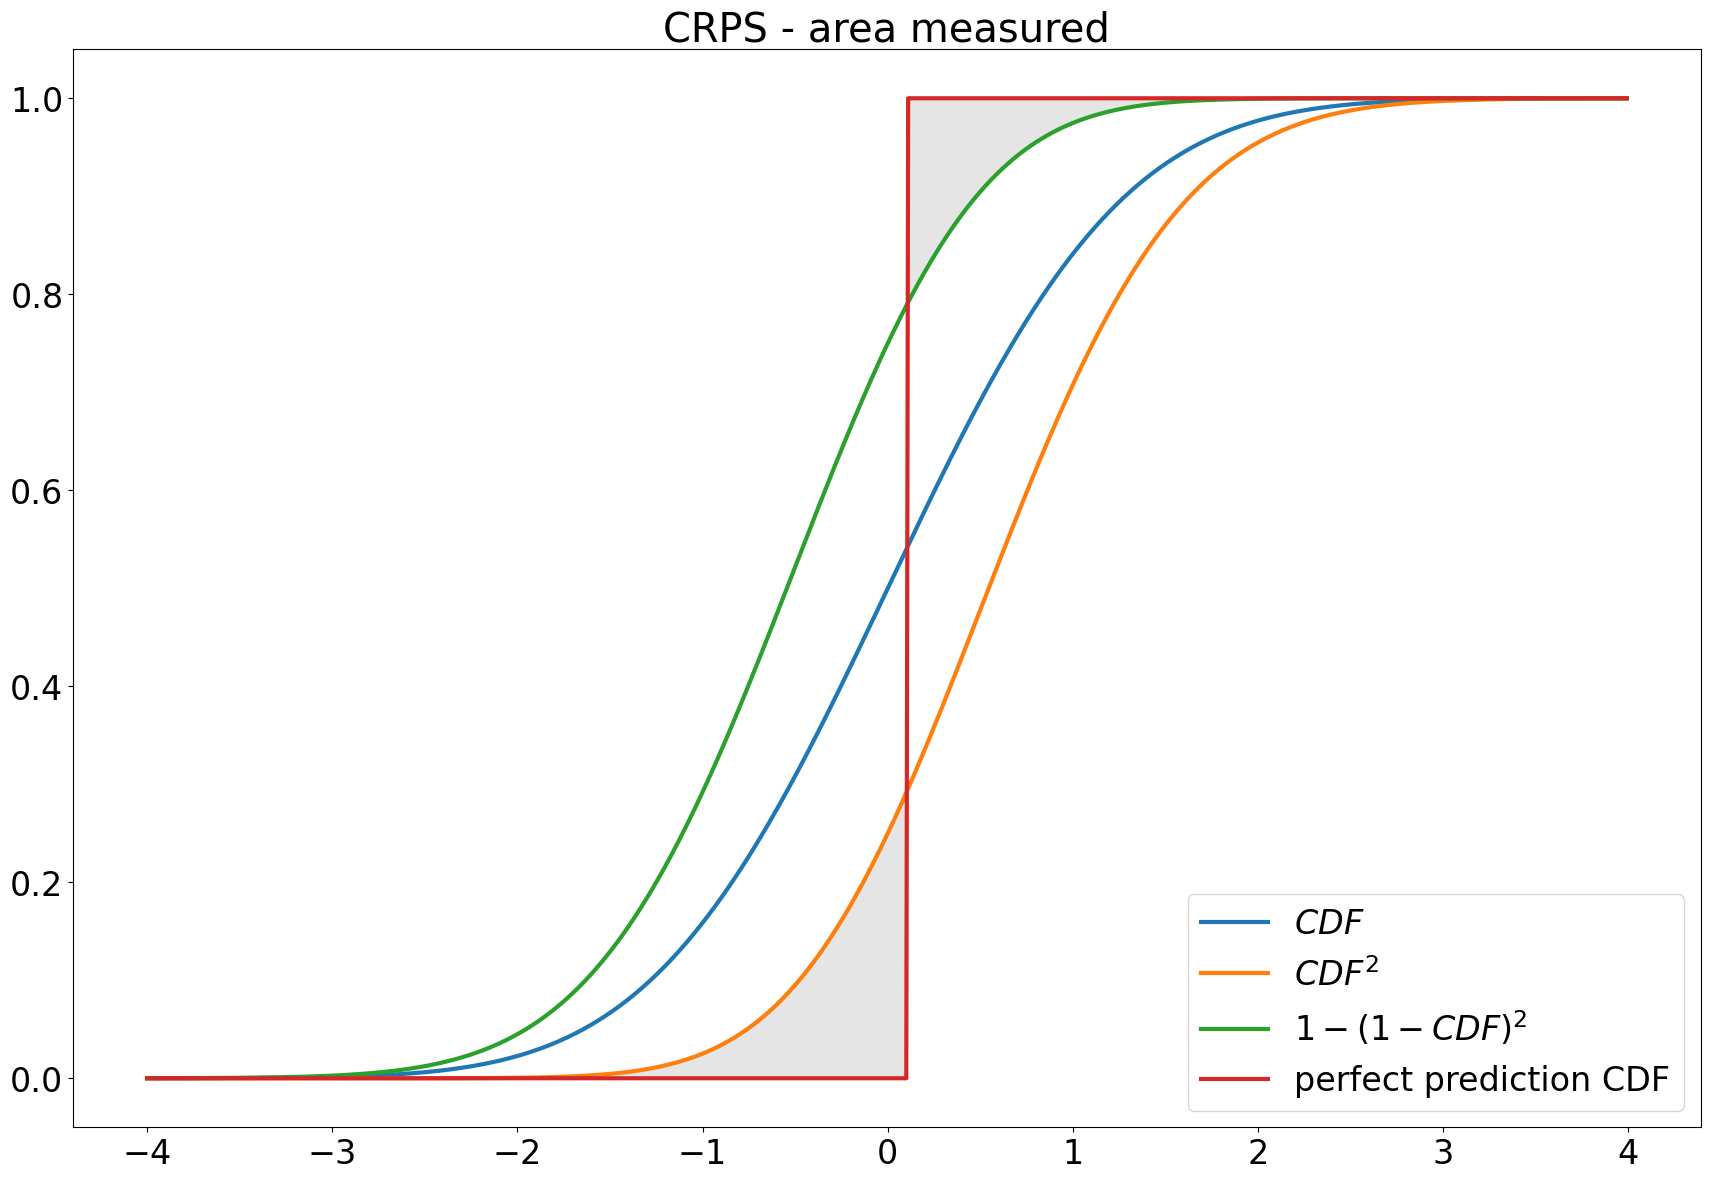

In [20]:
min_lim = -4
max_lim = 4
x_axis = np.arange(min_lim, max_lim, step=0.01)
dist = norm(0, 1)
perfect_pred = 1 * (x_axis > 0.1)

plt.plot(x_axis, dist.cdf(x_axis), label=r"$CDF$")
plt.plot(x_axis, dist.cdf(x_axis)**2, label=r"$CDF ^{2}$")
plt.plot(x_axis, 1 - (1 - dist.cdf(x_axis))**2, label=r"$1 - (1 - CDF) ^{2}$")
plt.plot(x_axis, perfect_pred, label="perfect prediction CDF")

plt.fill_between(
    x_axis,
    1 - (1 - dist.cdf(x_axis))**2,
    perfect_pred,
    where = 1 - (1 - dist.cdf(x_axis))**2 < perfect_pred,
    color="grey",
    alpha=0.2
)

plt.fill_between(
    x_axis,
    dist.cdf(x_axis)**2,
    perfect_pred,
    where = dist.cdf(x_axis)**2 > perfect_pred,
    color="grey",
    alpha=0.2
)

plt.title("CRPS - area measured")

plt.legend(loc="lower right")
plt.show()

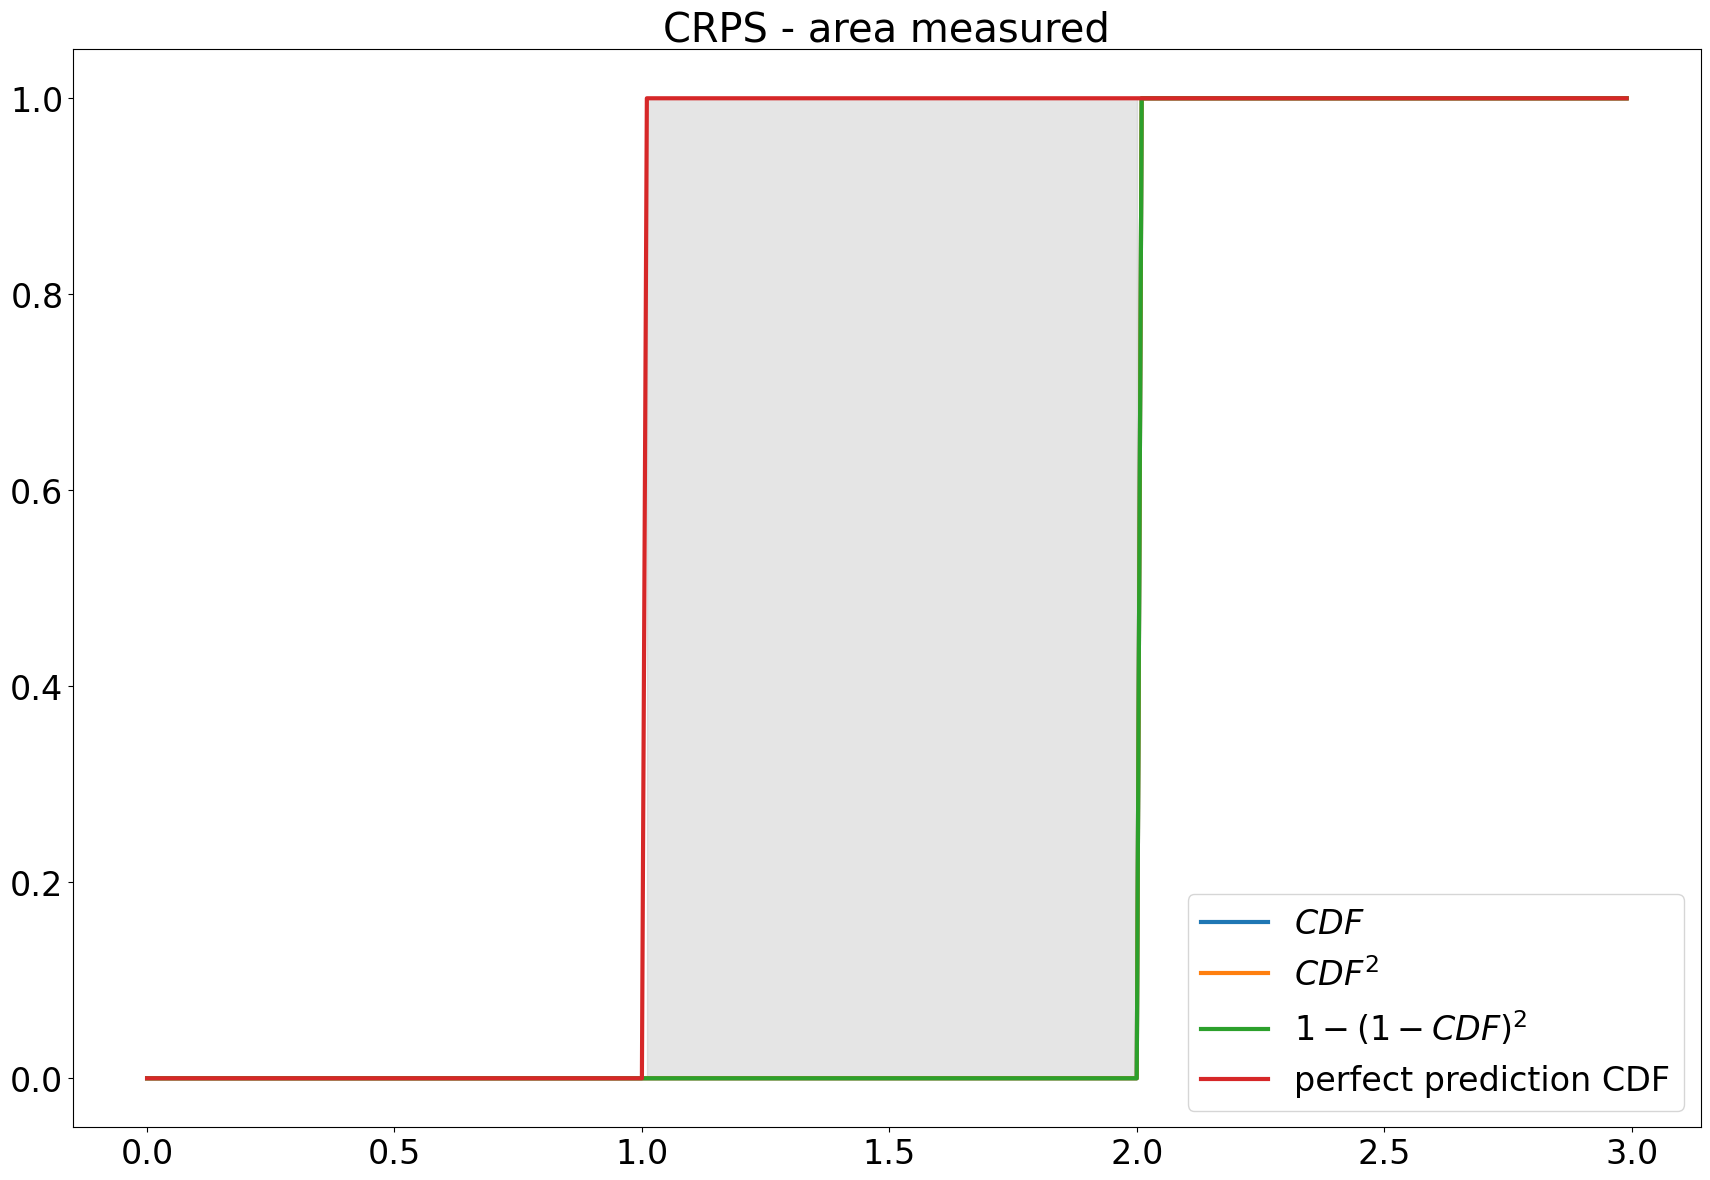

In [21]:
min_lim = 0
max_lim = 3
x_axis = np.arange(min_lim, max_lim, step=0.01)
pred = 1 * (x_axis > 2)
perfect_pred = 1 * (x_axis > 1)

plt.plot(x_axis, pred, label=r"$CDF$")
plt.plot(x_axis, pred**2, label=r"$CDF ^{2}$")
plt.plot(x_axis, 1 - (1 - pred)**2, label=r"$1 - (1 - CDF) ^{2}$")
plt.plot(x_axis, perfect_pred, label="perfect prediction CDF")

plt.fill_between(
    x_axis,
    1 - (1 - pred)**2,
    perfect_pred,
    where = 1 - (1 - pred)**2 < perfect_pred,
    color="grey",
    alpha=0.2
)

plt.fill_between(
    x_axis,
    pred**2,
    perfect_pred,
    where = pred**2 > perfect_pred,
    color="grey",
    alpha=0.2
)

plt.title("CRPS - area measured")
plt.legend(loc="lower right")
plt.show()

### Scipy distribution

In [22]:
def scipy_dist_crps(
    dist_list: List[rv_frozen],
    actuals: np.array,
    integration_lower_lim: float = -10000,
    integration_upper_lim: float = 10000,
    dx: float = 1,
) -> np.array:
    """CRPS for lists of scipy frozen distributions.
    
    Args:
        dist_list (List[rv_frozen]): list of scipy frozen distributions for each time
            step
        actuals (np.array): 1d array of the actual values
        integrarion_lower_lim (float, optional): upper limit for CRPS integral. 
            Defaults to -10000
        integrarion_upper_lim (float, optional): lower limit for CRPS integral. 
            Defaults to 10000
        dx(float, optional): dx for integration, only used for padding. 
            Defaults to 1
        
    Returns:
        np.array: vector of the CRPS score for each samples, actuals pair.
    """
    total_min = min(integration_lower_lim, np.min(actuals))
    total_max = max(integration_upper_lim, np.max(actuals))

    x_axis = np.arange(start=total_min, stop=total_max, step=dx)

    cdfs = [dist.cdf(x_axis) for dist in dist_list]

    # Perfect prediction cdf
    repeated_actuals = np.expand_dims(actuals, axis=1)
    perfect_prediction = 1 * x_axis >= repeated_actuals

    # Numerical integral calculation
    crps_vector = np.trapz((cdfs - perfect_prediction) ** 2, x_axis, axis=1)
    return crps_vector

/var/folders/rz/q8bv6kt16qn0jp923jhqp58h0000gn/T/ipykernel_65823/3931382383.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  crps_vector = np.trapz((cdfs - perfect_prediction) ** 2, x_axis, axis=1)


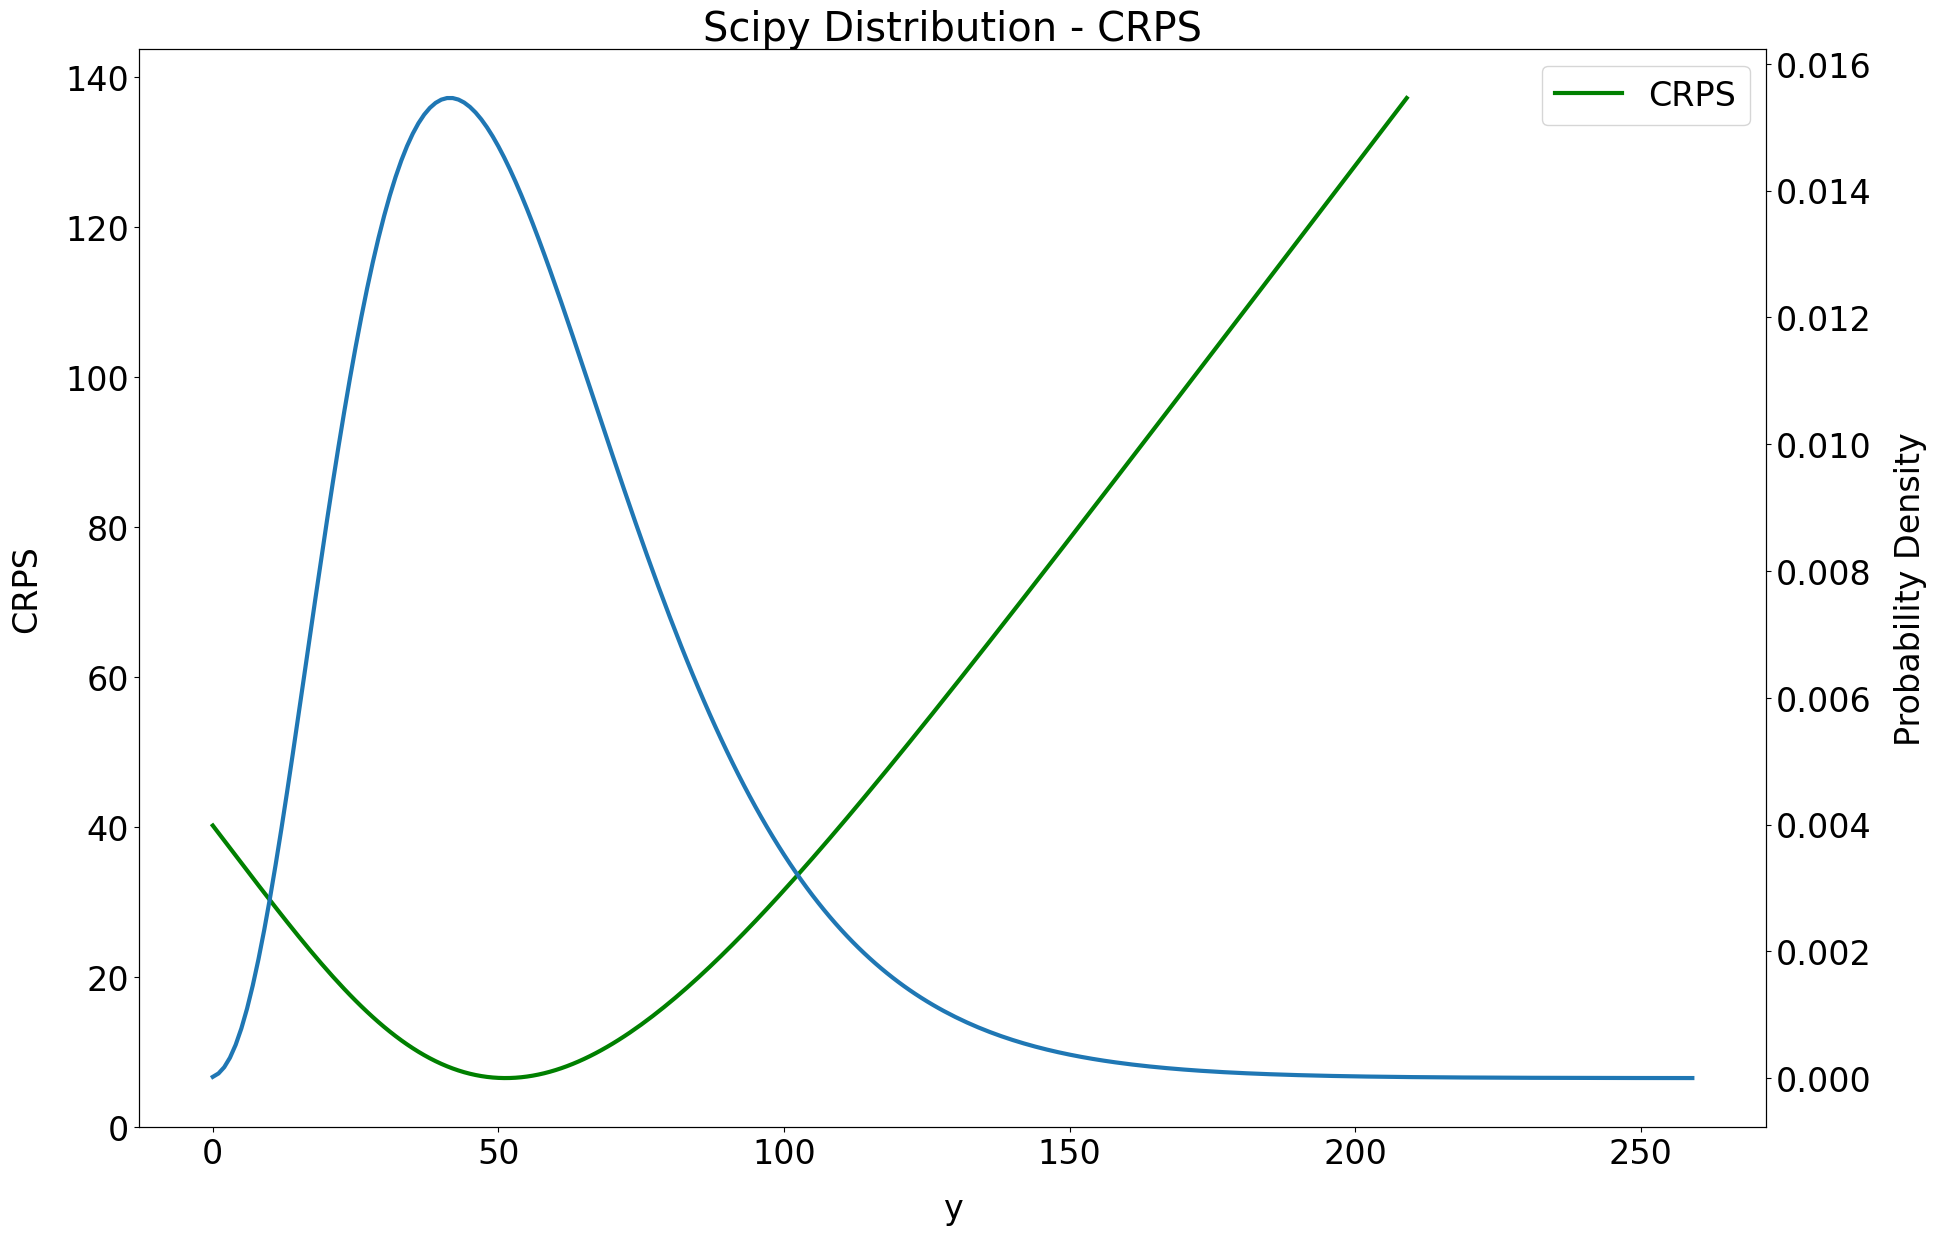

In [23]:
crps_score = scipy_dist_crps(dist_list, actuals)

fig, ax1 = plt.subplots()

min_lim = 0
max_lim = 260
x_axis = np.arange(min_lim, max_lim, step=1)

ax2 = ax1.twinx()
ax2.plot(x_axis, frozen_dist.pmf(x_axis), label='Distribution PDF')
ax1.plot(actuals, crps_score, color="g", label="CRPS")

plt.title(f"Scipy Distribution - CRPS")
ax2.set_ylabel("Probability Density")
ax1.set_ylabel("CRPS")
ax1.set_xlabel("y")
ax1.legend()
plt.show()

### Samples

In [24]:
def sample_crps(
    samples: np.array,
    actuals: np.array,
    integration_lower_lim: float = -10000,
    integration_upper_lim: float = 10000,
    dx: float = 1,
) -> np.array:
    """CRPS for samples.
    
    Args:
        samples (np.array): 2d array of sampled paths. 1st dim is time, 2nd dim is
            number of samples
        actuals (np.array): 1d array of the actual values
        integrarion_lower_lim (float, optional): upper limit for CRPS integral.
            Defaults to -10000
        integrarion_upper_lim (float, optional): lower limit for CRPS integral.
            Defaults to 10000
        dx (float, optional): dx for integration, only used for padding. 
            Defaults to 1
        
    Returns:
        np.array: vector of the CRPS score for each samples, actuals pair.
    """
    sample_min = np.min(samples)
    sample_max = np.max(samples)

    total_min = min(sample_min, integration_lower_lim, np.min(actuals))
    total_max = max(sample_max, integration_upper_lim, np.max(actuals))

    pad_width_tuple = (
        int(np.abs(sample_min - total_min) / dx),
        int(np.abs(total_max - sample_max) / dx),
    )

    # T: number of time steps
    # N: number of samples in time step
    T, N = samples.shape

    # Sorted observations and rank (for empirical cdf)
    sorted_samples = np.sort(samples, axis=1)
    sorted_samples_rank_single = np.arange(N) / N
    sorted_samples_rank = np.tile(sorted_samples_rank_single, (T, 1))

    # Padding - necessary for the numerical integration
    padded_sorted = np.pad(
        sorted_samples,
        pad_width=[(0, 0), pad_width_tuple],
        mode="linear_ramp",
        end_values=(total_min, total_max),
    )

    padded_sorted_rank = np.pad(
        sorted_samples_rank,
        pad_width=[(0, 0), pad_width_tuple],
        mode="constant",
        constant_values=(0, 1),
    )

    # Perfect prediction cdf
    repeated_actuals = np.expand_dims(actuals, axis=1)
    perfect_prediction = 1 * padded_sorted >= repeated_actuals

    # Numerical integral calculation
    crps_vector = np.trapz(
        (padded_sorted_rank - perfect_prediction) ** 2, padded_sorted, axis=1
    )
    return crps_vector

/var/folders/rz/q8bv6kt16qn0jp923jhqp58h0000gn/T/ipykernel_65823/2000424417.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  crps_vector = np.trapz(


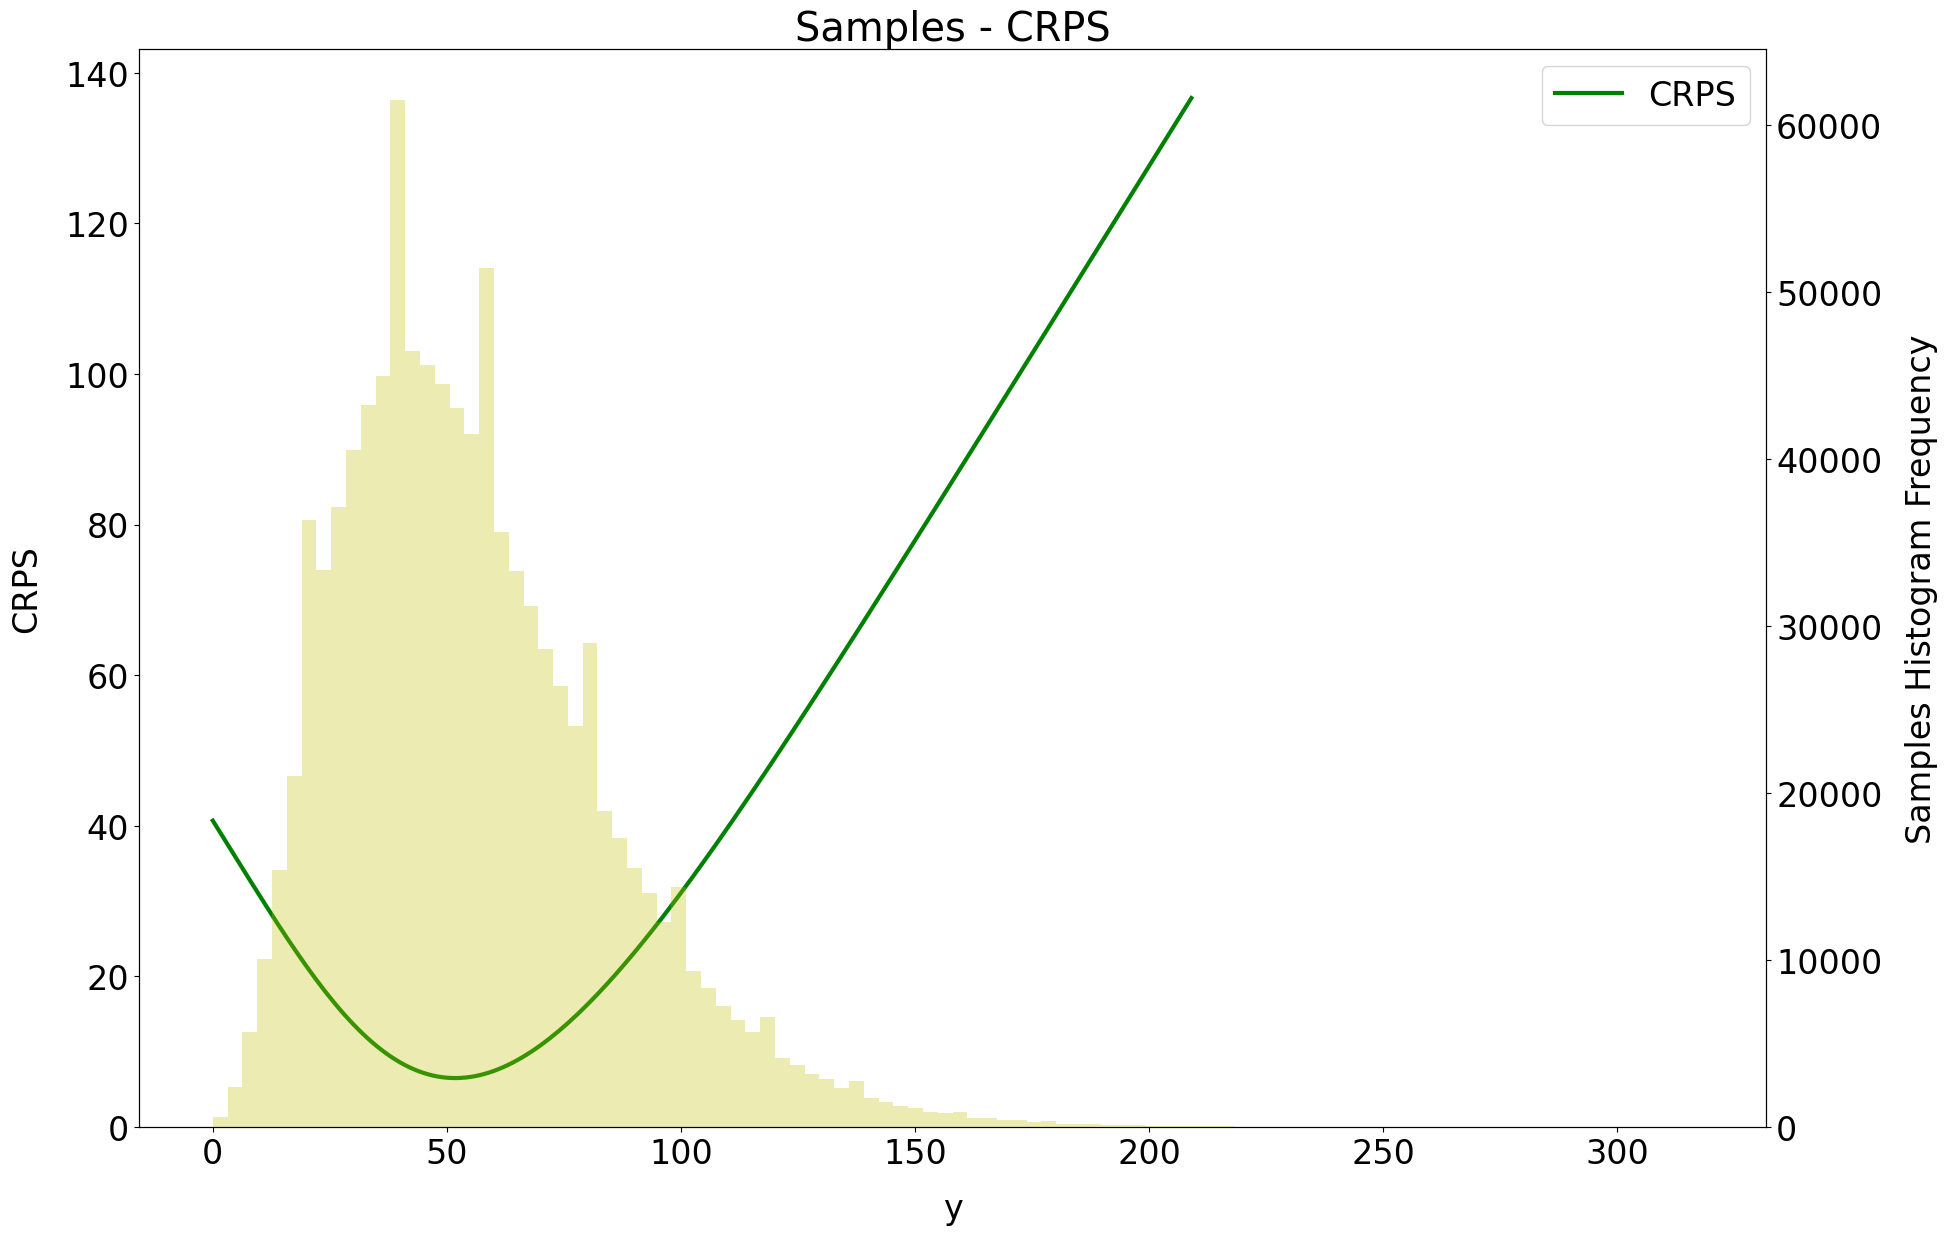

In [25]:
crps_score = sample_crps(samples, actuals)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.hist(
    samples_single, 
    bins=100, 
    edgecolor='None', 
    alpha = 0.3, 
    color= 'y', 
    label="Samples Histogram"
)
ax1.plot(actuals, crps_score , color="g", label="CRPS")

plt.title(f"Samples - CRPS")
ax2.set_ylabel("Samples Histogram Frequency")
ax1.set_ylabel("CRPS")
ax1.set_xlabel("y")
ax1.legend()
plt.show()

### Proper scoring property illustration

  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/rz/q8bv6kt16qn0jp923jhqp58h0000gn/T/ipykernel_65823/3931382383.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  crps_vector = np.trapz((cdfs - perfect_prediction) ** 2, x_axis, axis=1)
100%|██████████| 50/50 [21:22<00:00, 25.65s/it]


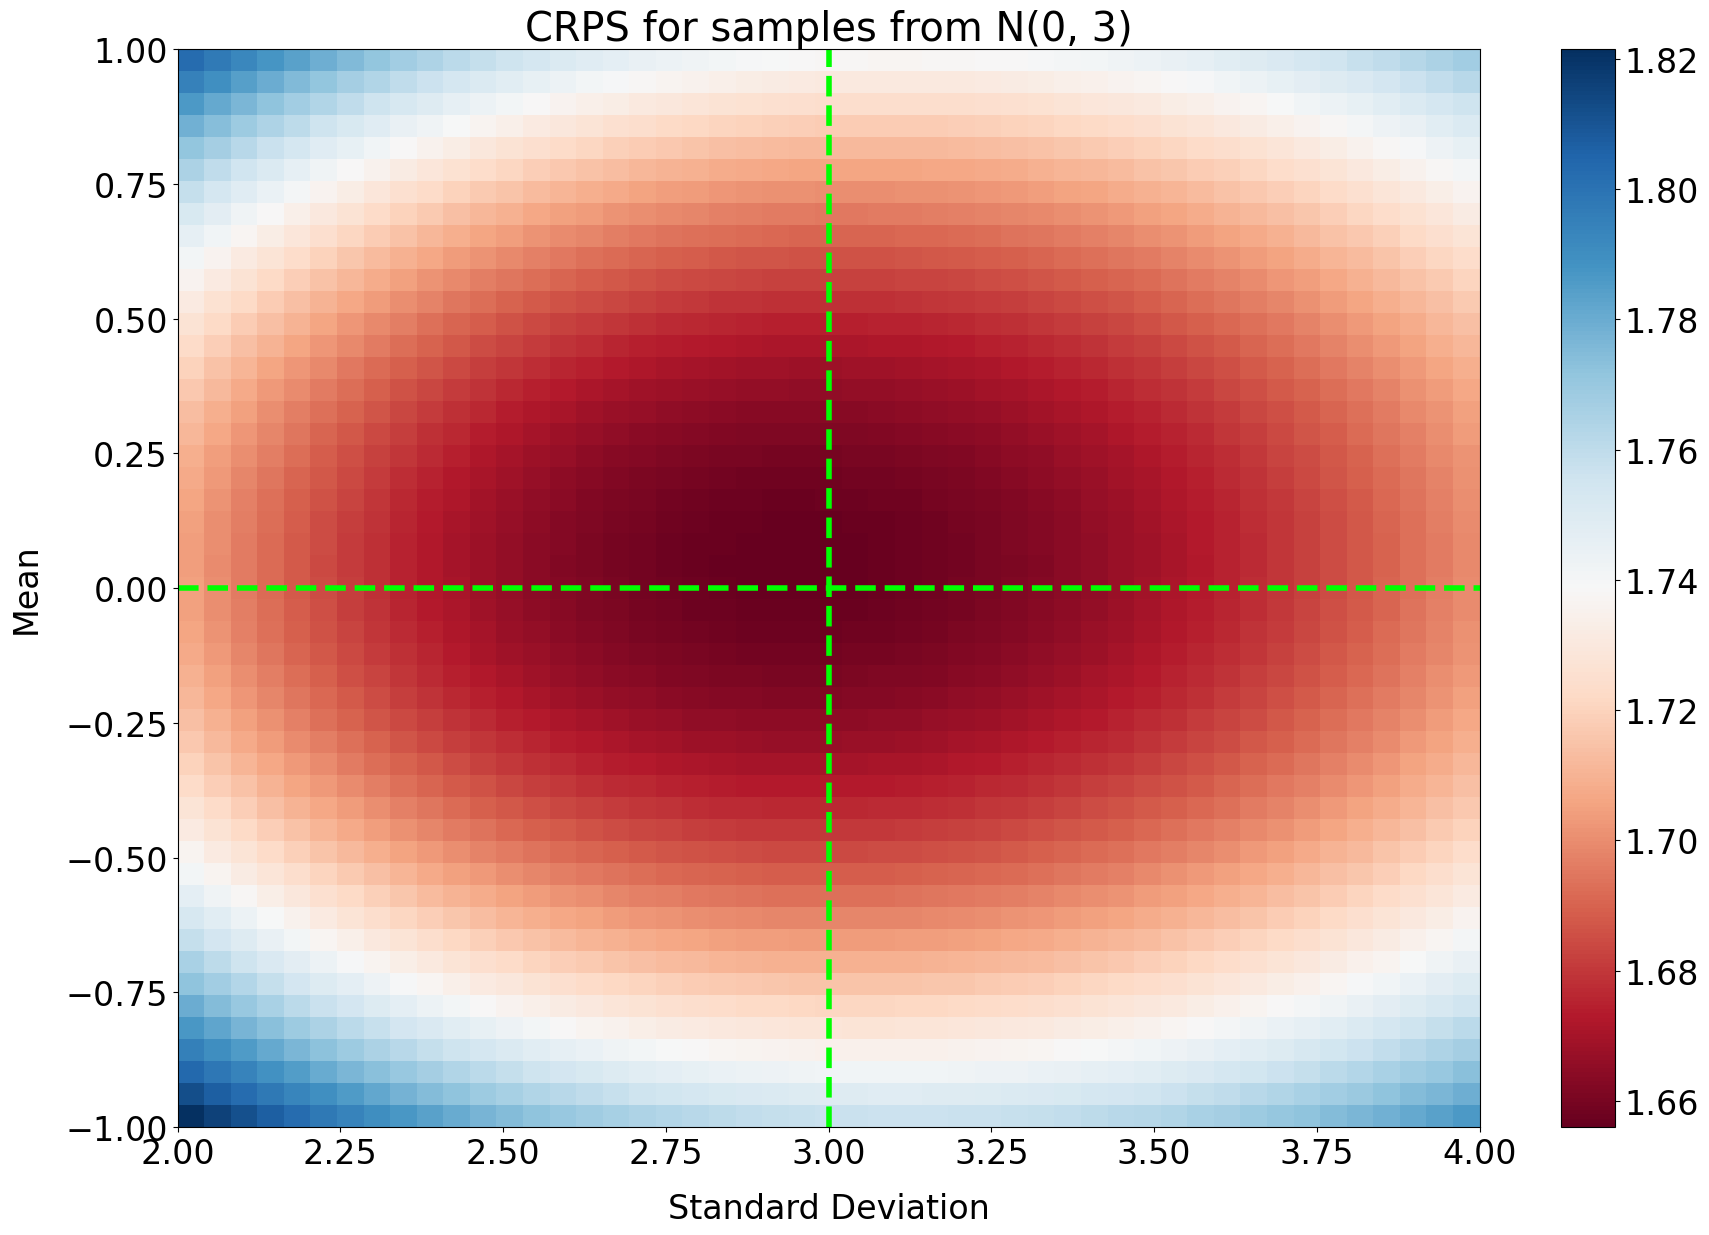

In [26]:
# Note: this code will take a while to run :(
data_gen_dist = norm(0, 3)
real_samples = data_gen_dist.rvs(size=1000, random_state=42)

N = 50
mu_space, sigma_space = y, x = np.meshgrid(np.linspace(-1, 1, N), np.linspace(2, 4, N))
crps_matrix = np.empty((N, N))
for i in tqdm(range(N)):
    for j in range(N):
        mu = mu_space[i][j]
        sigma = sigma_space[i][j]
        tmp_dist_list = [norm(mu, sigma) for _ in range(len(real_samples))]
        score = scipy_dist_crps(tmp_dist_list, real_samples)
        crps_matrix[i ,j] = np.mean(score)

# Plot
x = sigma_space
y = mu_space
z = crps_matrix

# generate 2 2d grids for the x & y bounds
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('CRPS for samples from N(0, 3)')
# set the limits of the plot to the limits of the data
ax.set_ylabel("Mean")
ax.set_xlabel("Standard Deviation")
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.vlines(3, -1, 1, linestyles="dashed", color="lime", linewidth=4)
ax.hlines(0, 2, 4, linestyles="dashed", color="lime", linewidth=4)
fig.colorbar(c, ax=ax)
plt.show()

# Weighted Interval Score as an approximation to the CRPS

In [27]:
def scipy_dist_weighted_interval_score(
    dist_list: List[rv_frozen],
    actuals: np.array,
    alphas: List[float] = None,
    weights: List[float] = None,
) -> np.array:
    """Weighted Interval Score for scipy frozen distributions

    Args:
        dist_list (List[rv_frozen]): list of scipy frozen distributions for each time
            step
        actuals (np.array): 1d array of the actual values
        alphas (List[float], optional): List of prediction intervals aplhas.
            Defaults to None. If None, then [0.1, 0.2, 0.3, 0.4] is used.
        weights (List[float], optional): Weights for each interval.
            Weights should be len(alphas)+1. Where weights[0] is the weight for the
            median score. Defaults to None. If None then weights are alpha/2 for each
            alpha and 0.5 for weights[0].

    Returns:
        np.array: Weighted Interval Scores vector
    """
    alphas = np.array(alphas) if alphas is not None else np.array([0.1, 0.2, 0.3, 0.4])
    K = len(alphas)
    alphas = np.expand_dims(alphas, axis=0)

    if weights is None:
        weight_0 = 0.5
        weights = alphas / 2
    else:
        weight_0 = weights[0]
        weights = np.array(weights[1:])
        weights = np.expand_dims(weights, axis=0)

    y_upper = np.squeeze(np.array([dist.ppf(1 - alphas / 2) for dist in dist_list]))
    y_lower = np.squeeze(np.array([dist.ppf(alphas / 2) for dist in dist_list]))
    medians = np.expand_dims(np.array([dist.median() for dist in dist_list]), axis=1)
    actuals = np.expand_dims(actuals, axis=1)

    interval_scores_matrix = (
        (y_upper - y_lower)
        + (2 / alphas) * (y_lower - actuals) * (actuals < y_lower)
        + (2 / alphas) * (actuals - y_upper) * (actuals > y_upper)
    )

    is_sums = np.sum(interval_scores_matrix * weights, axis=1)
    is_sums = np.expand_dims(is_sums, axis=1)
    median_score = weight_0 * np.abs(actuals - medians)
    weighted_interval_score = (1 / (K + 1 / 2)) * (median_score + is_sums)

    return weighted_interval_score

/var/folders/rz/q8bv6kt16qn0jp923jhqp58h0000gn/T/ipykernel_65823/3931382383.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  crps_vector = np.trapz((cdfs - perfect_prediction) ** 2, x_axis, axis=1)


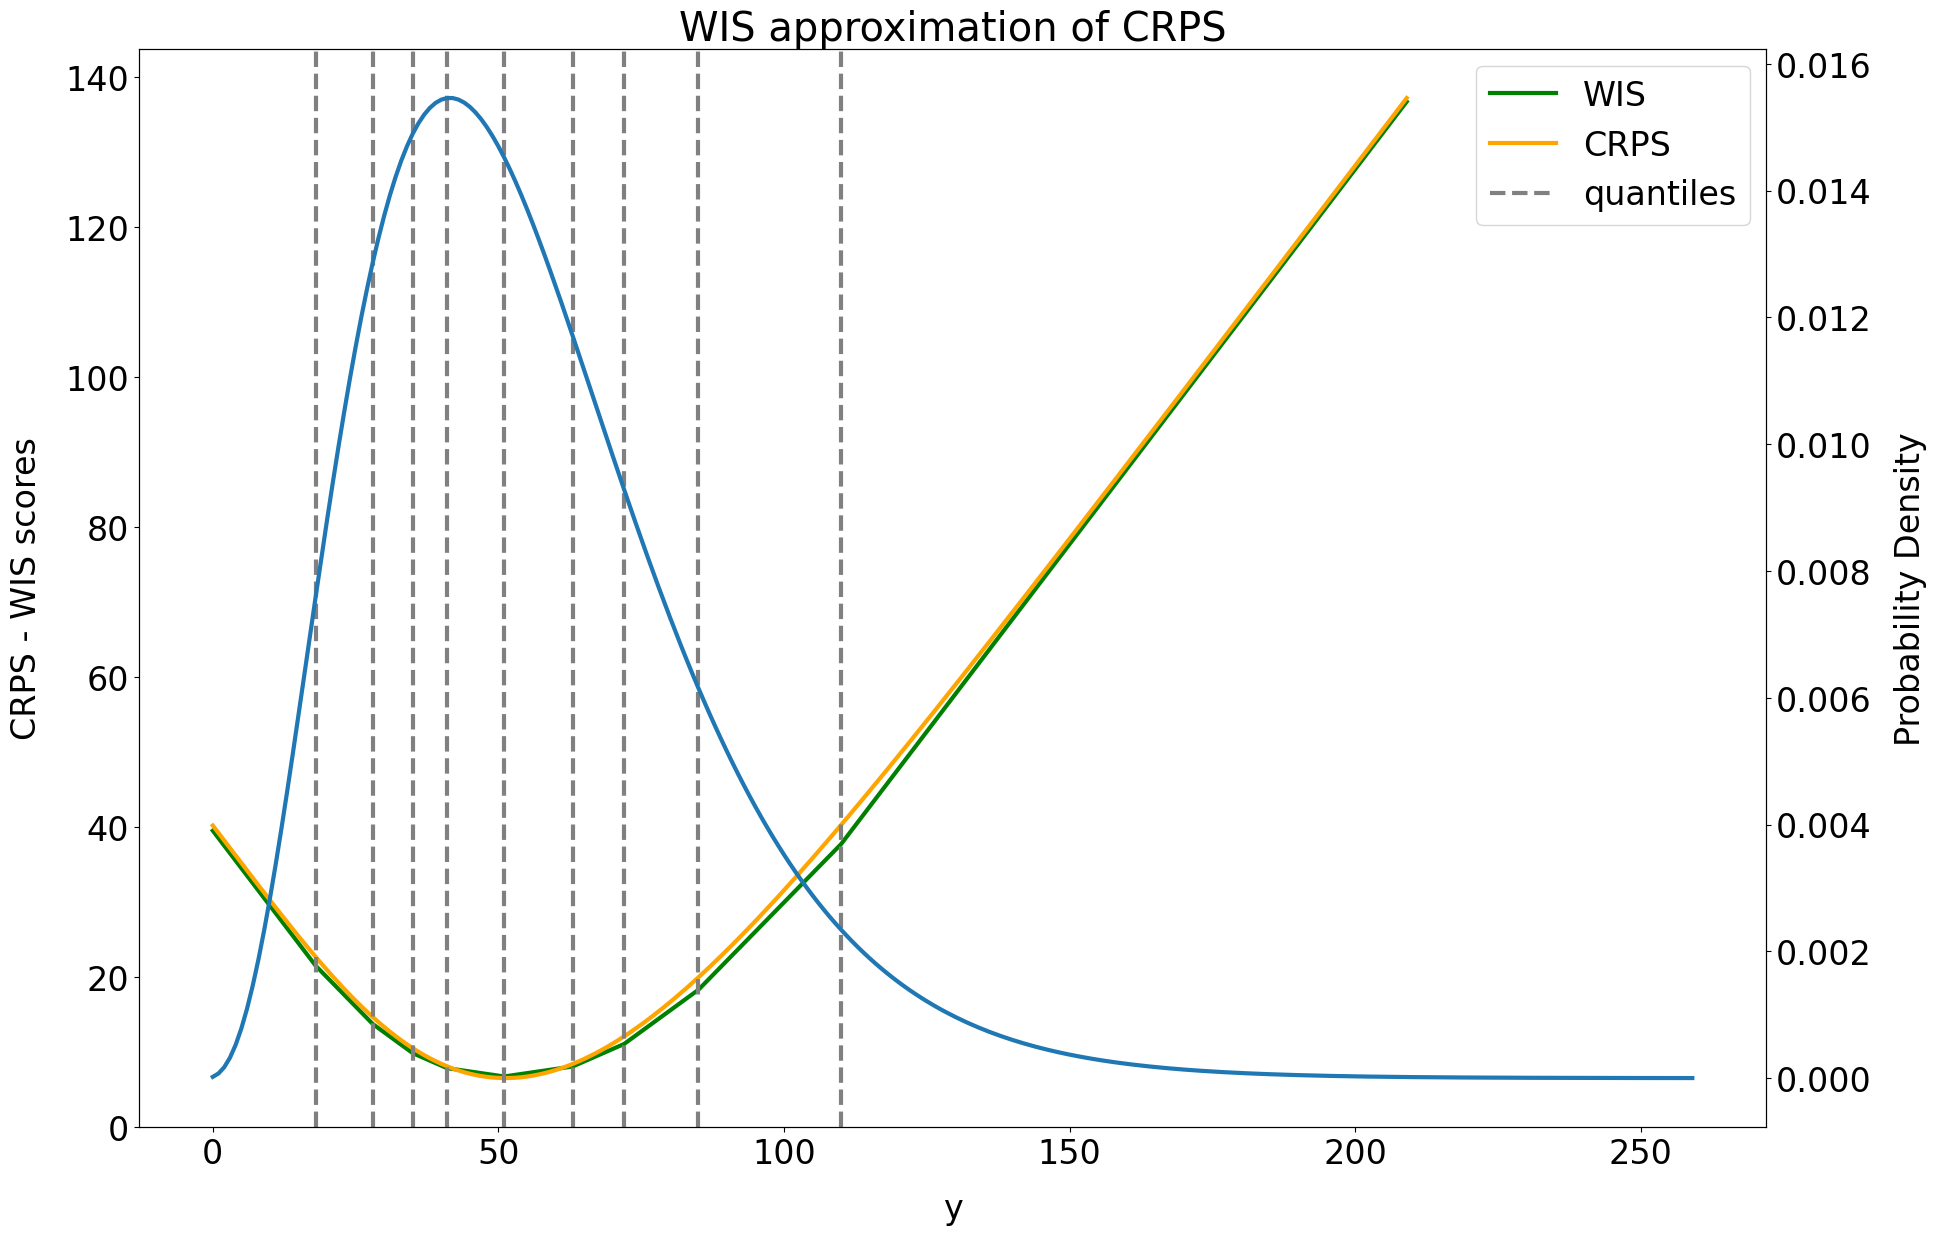

In [28]:
alphas = np.arange(0.1, 0.9, 0.2)
wis_score = scipy_dist_weighted_interval_score(dist_list, actuals, alphas)
crps_score = scipy_dist_crps(dist_list, actuals)

fig, ax1 = plt.subplots()

min_lim = 0
max_lim = 260
x_axis = np.arange(min_lim, max_lim, step=1)

ax2 = ax1.twinx()
ax2.plot(x_axis, frozen_dist.pmf(x_axis), label='PDF')
ax1.plot(actuals, wis_score, color="g", label="WIS")
ax1.plot(actuals, crps_score, color="orange", label="CRPS")

ax1.axvline(dist_list[0].ppf(0.5), linestyle="--", color="grey", label="quantiles")
for a in alphas:
    ax1.axvline(dist_list[0].ppf(1-a/2), linestyle="--", color="grey")
    ax1.axvline(dist_list[0].ppf(a/2), linestyle="--", color="grey")

plt.title(f"WIS approximation of CRPS")
ax2.set_ylabel("Probability Density")
ax1.set_ylabel("CRPS - WIS scores")
ax1.set_xlabel("y")
ax1.legend()
plt.show()

# Bimodal distribution Example for local VS distance sensitive scores

/var/folders/rz/q8bv6kt16qn0jp923jhqp58h0000gn/T/ipykernel_65823/3931382383.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  crps_vector = np.trapz((cdfs - perfect_prediction) ** 2, x_axis, axis=1)


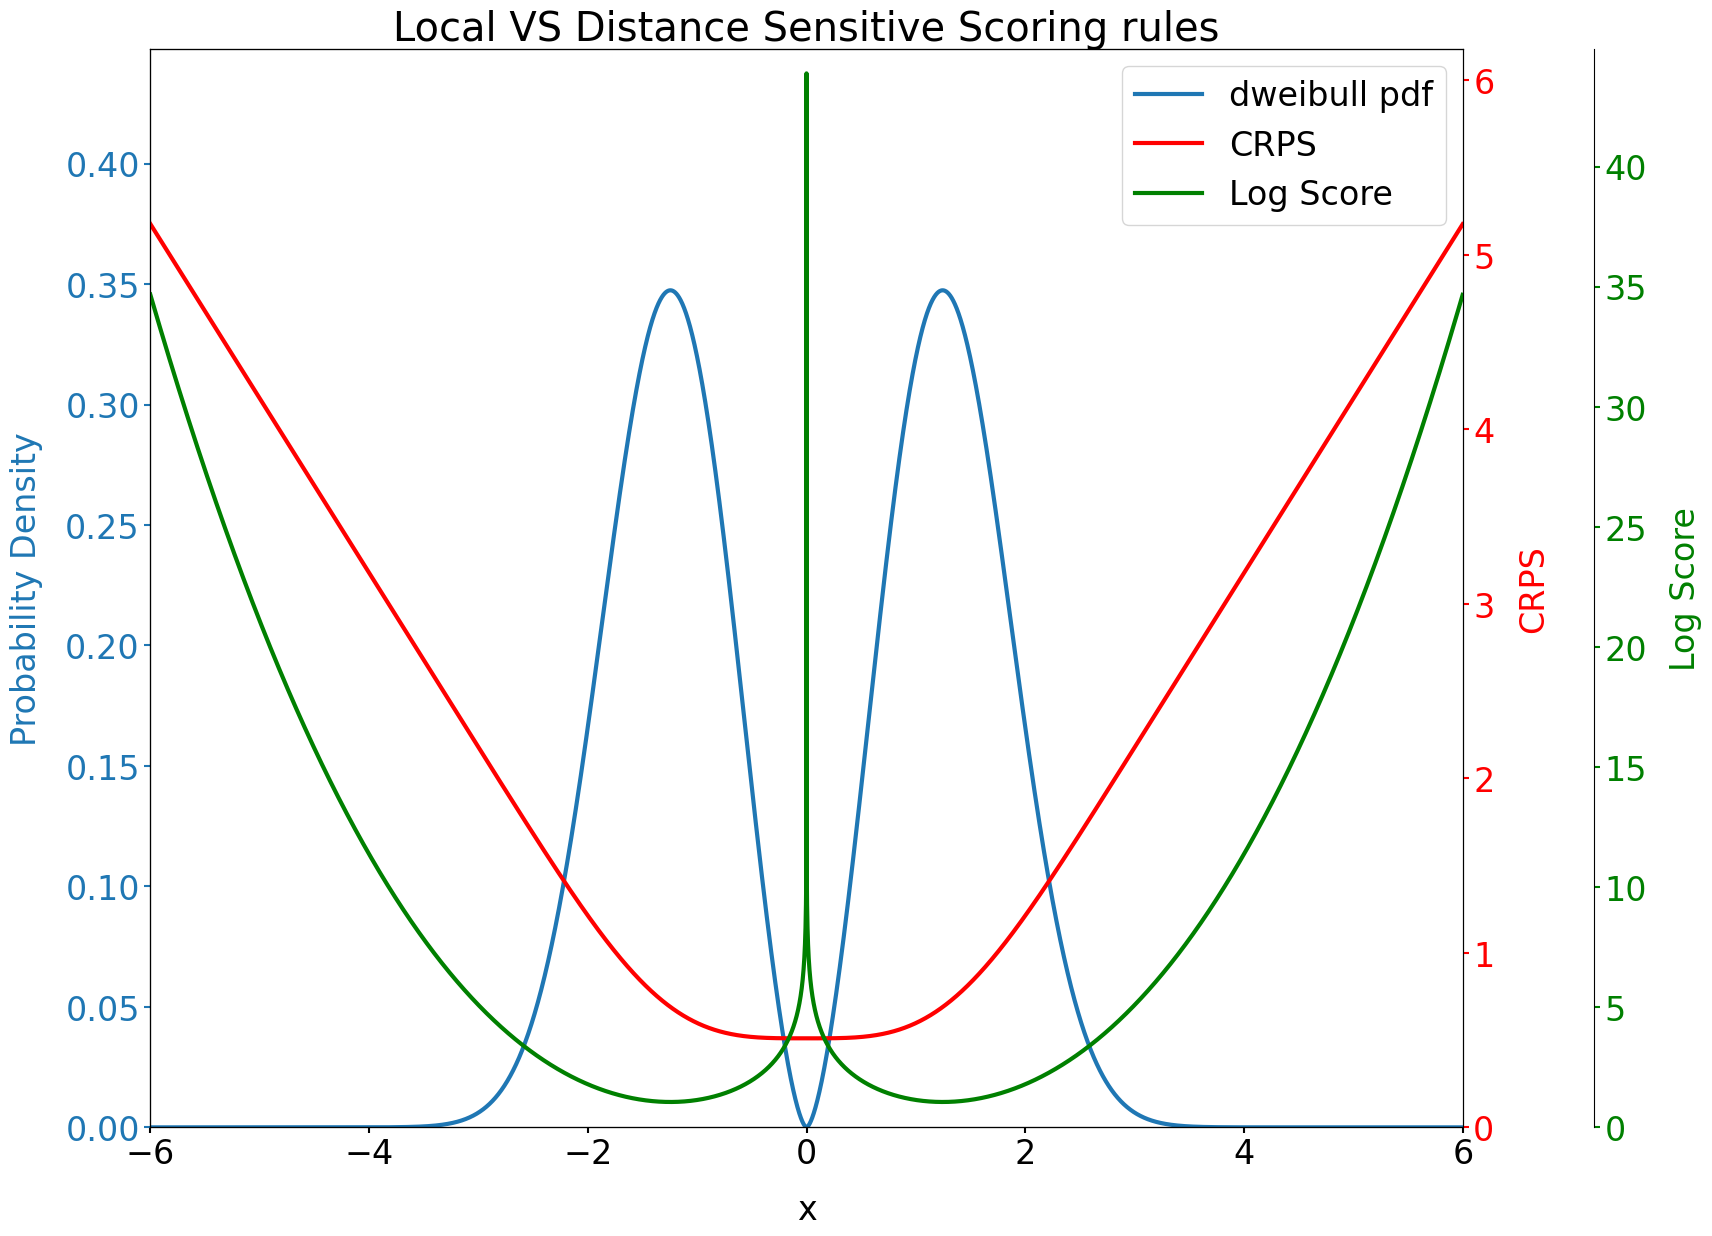

In [29]:
dist = dweibull(c=2.6, loc=0, scale=1.5)
min_lim = -6
max_lim = 6
x_axis = np.arange(min_lim, max_lim, step=0.001)
dist_list = [deepcopy(dist) for _ in range(len(x_axis))]

crps = scipy_dist_crps(
    dist_list, 
    x_axis, 
    dx=0.001, 
    integration_lower_lim=-20, 
    integration_upper_lim=20
)

log_score = scipy_dist_log_score(dist_list, x_axis)

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()

twin2.spines.right.set_position(("axes", 1.1))

p1, = ax.plot(x_axis, dist.pdf(x_axis), label='dweibull pdf')
p2, = twin1.plot(x_axis, crps, "r-", label="CRPS")
p3, = twin2.plot(x_axis, log_score, "g-", label="Log Score")

ax.set_xlim(min_lim, max_lim)
ax.set_ylim(0, np.max(dist.pdf(x_axis)) + 0.1)
twin1.set_ylim(0, np.max(crps)+1)
twin2.set_ylim(0, np.max(log_score) + 1)

ax.set_xlabel("x")
ax.set_ylabel("Probability Density")
twin1.set_ylabel("CRPS")
twin2.set_ylabel("Log Score")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])
plt.title(f"Local VS Distance Sensitive Scoring rules")
plt.show()

# Putting it all together

### Simulation examples

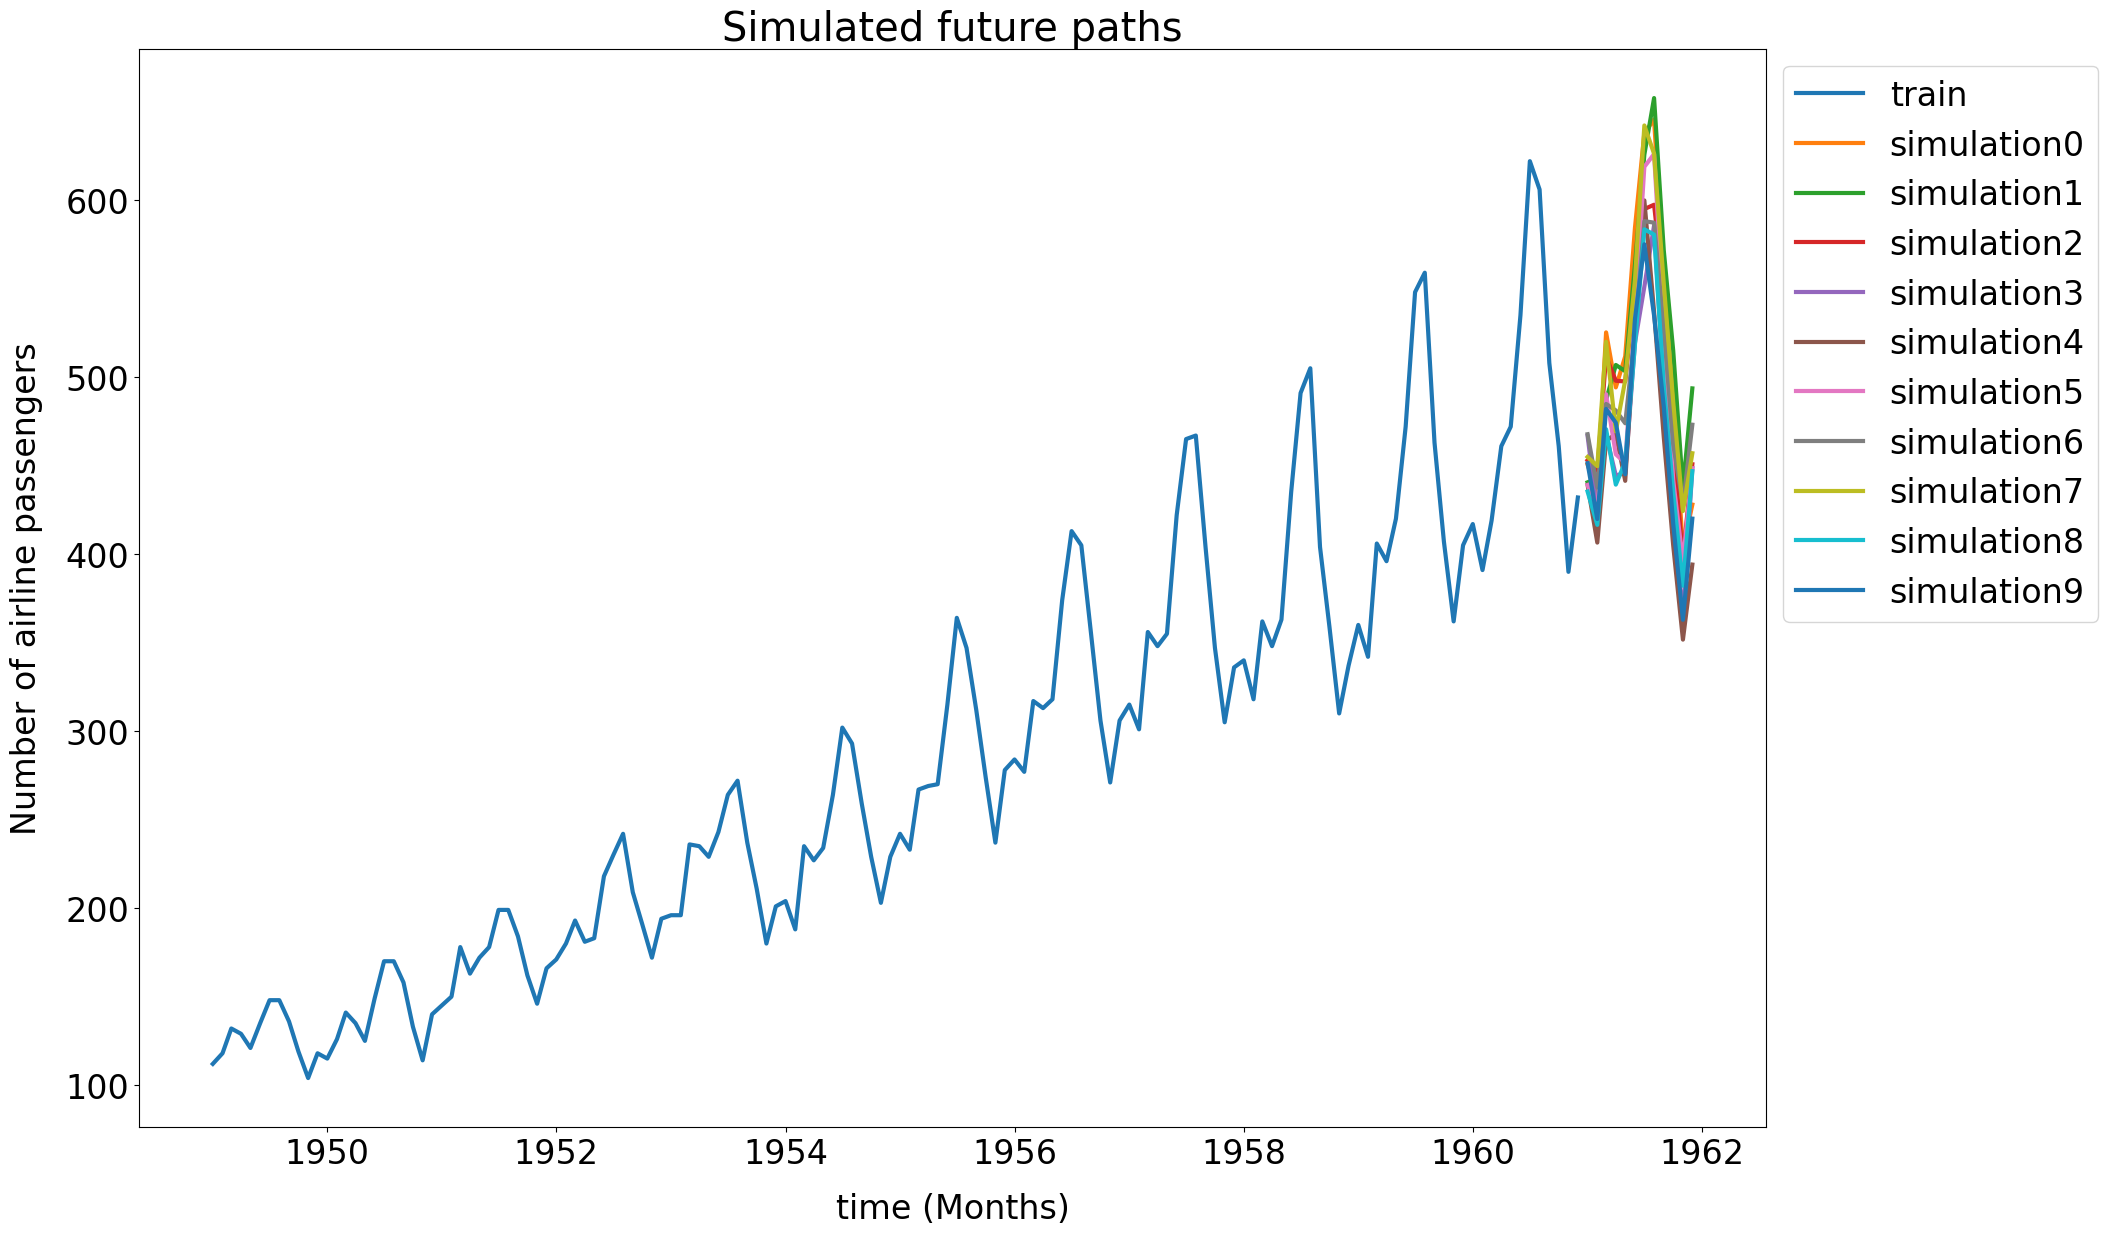

In [32]:
# example data 
y = load_airline(return_array=False)
y.index = y.index.to_timestamp()  

model = ETSModel(
    endog=y, 
    seasonal_periods=12, 
    error="mul", 
    seasonal="mul", 
    trend="add"
)
results = model.fit(disp=0)
sims = results.simulate(
    nsimulations=12, 
    repetitions=10, 
    anchor="end", 
    random_state=42
)

plt.plot(y, label="train")
plt.plot(
    sims, 
    label=["simulation"+str(i) for i in range(len(sims.columns))]
)
plt.xlabel(f"time (Months)")
plt.ylabel(y.name)
plt.title("Simulated future paths")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Comparing different moddels

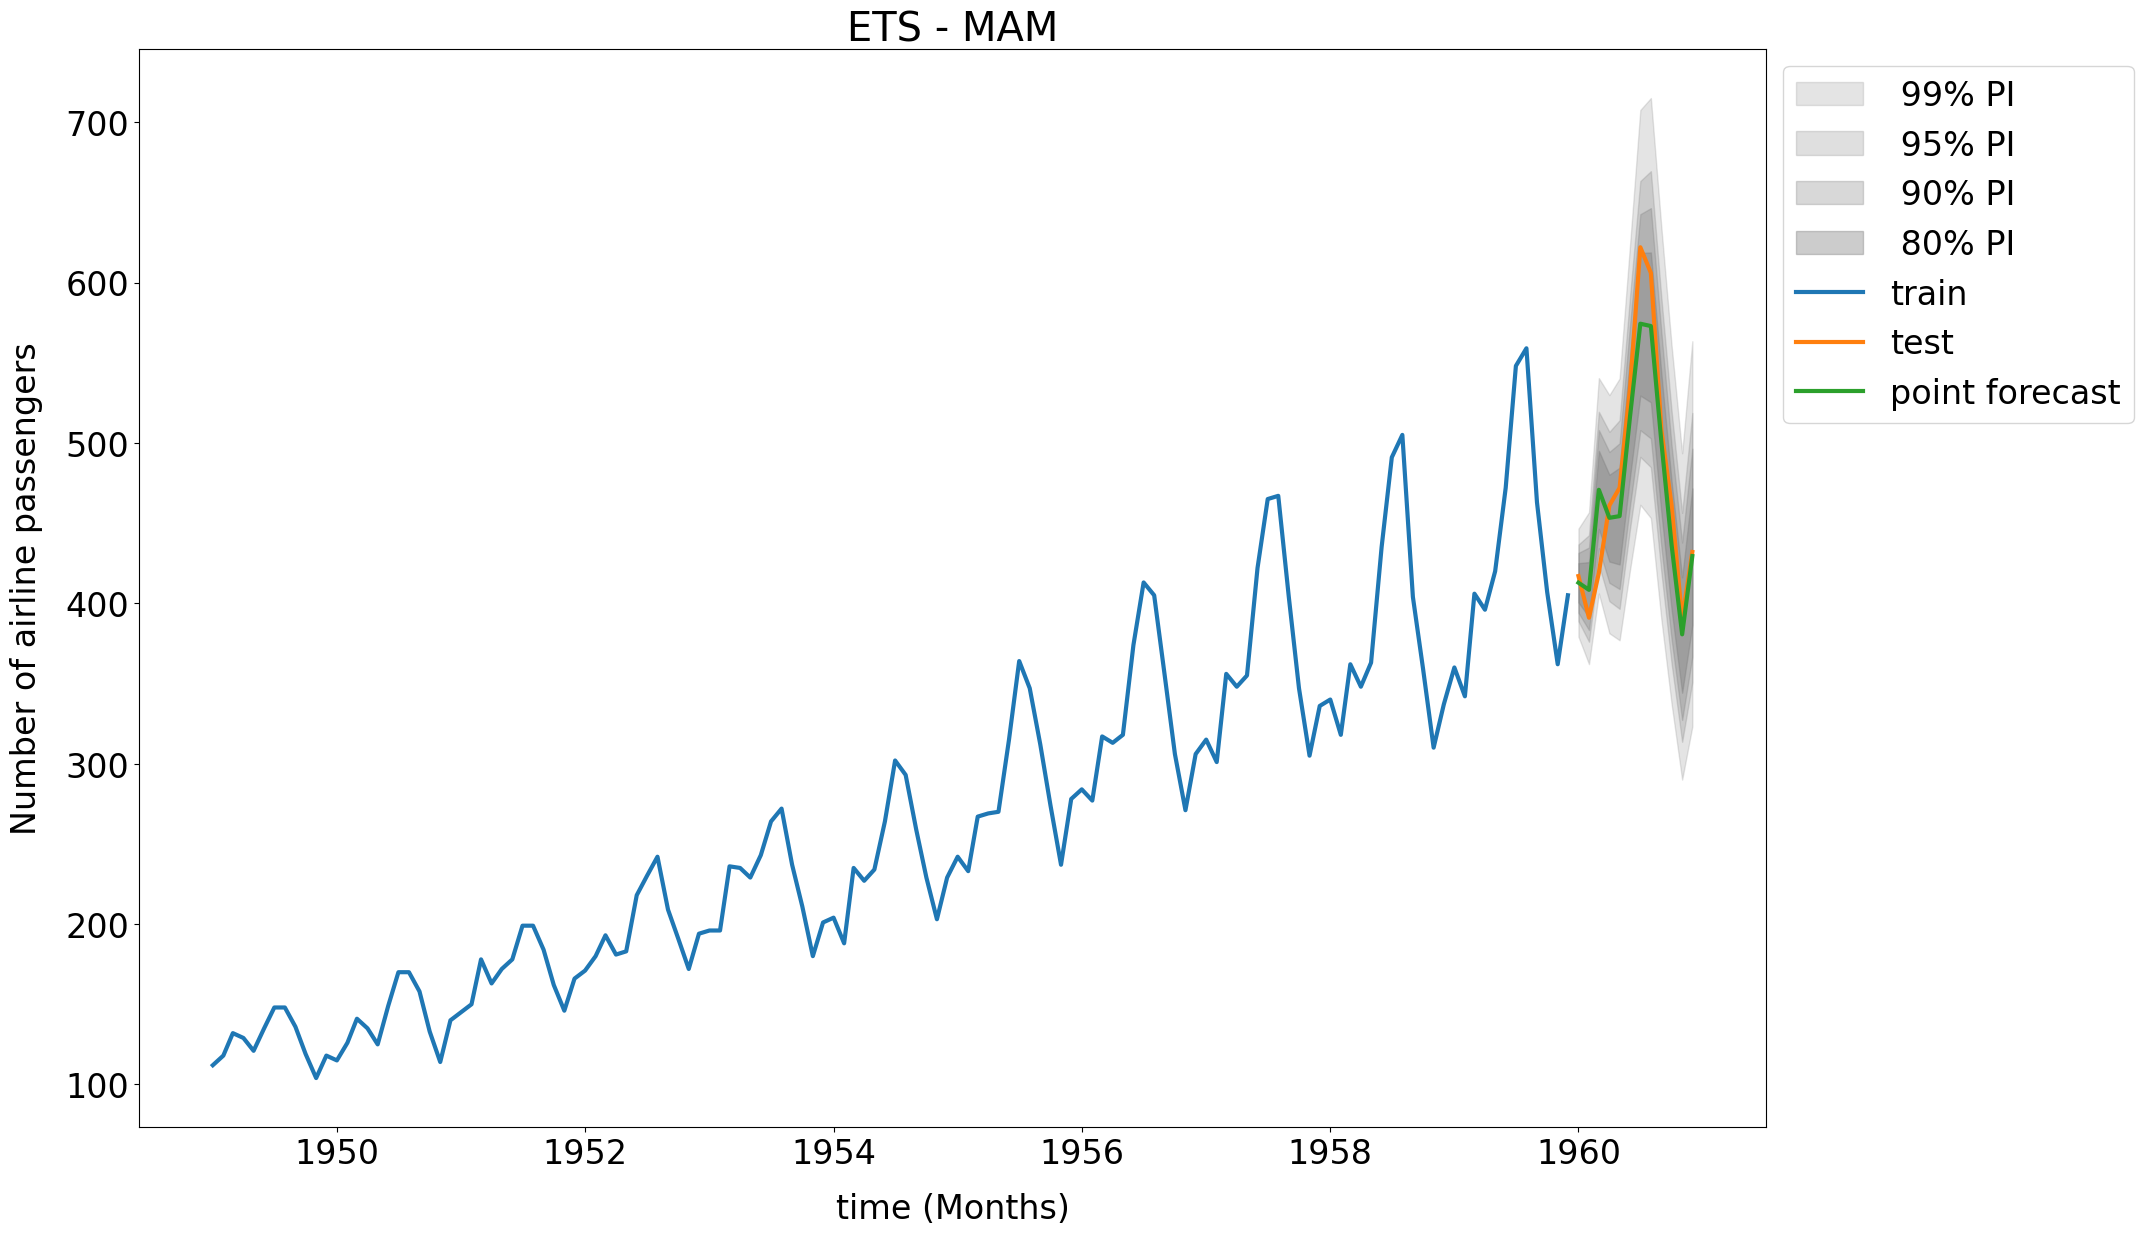

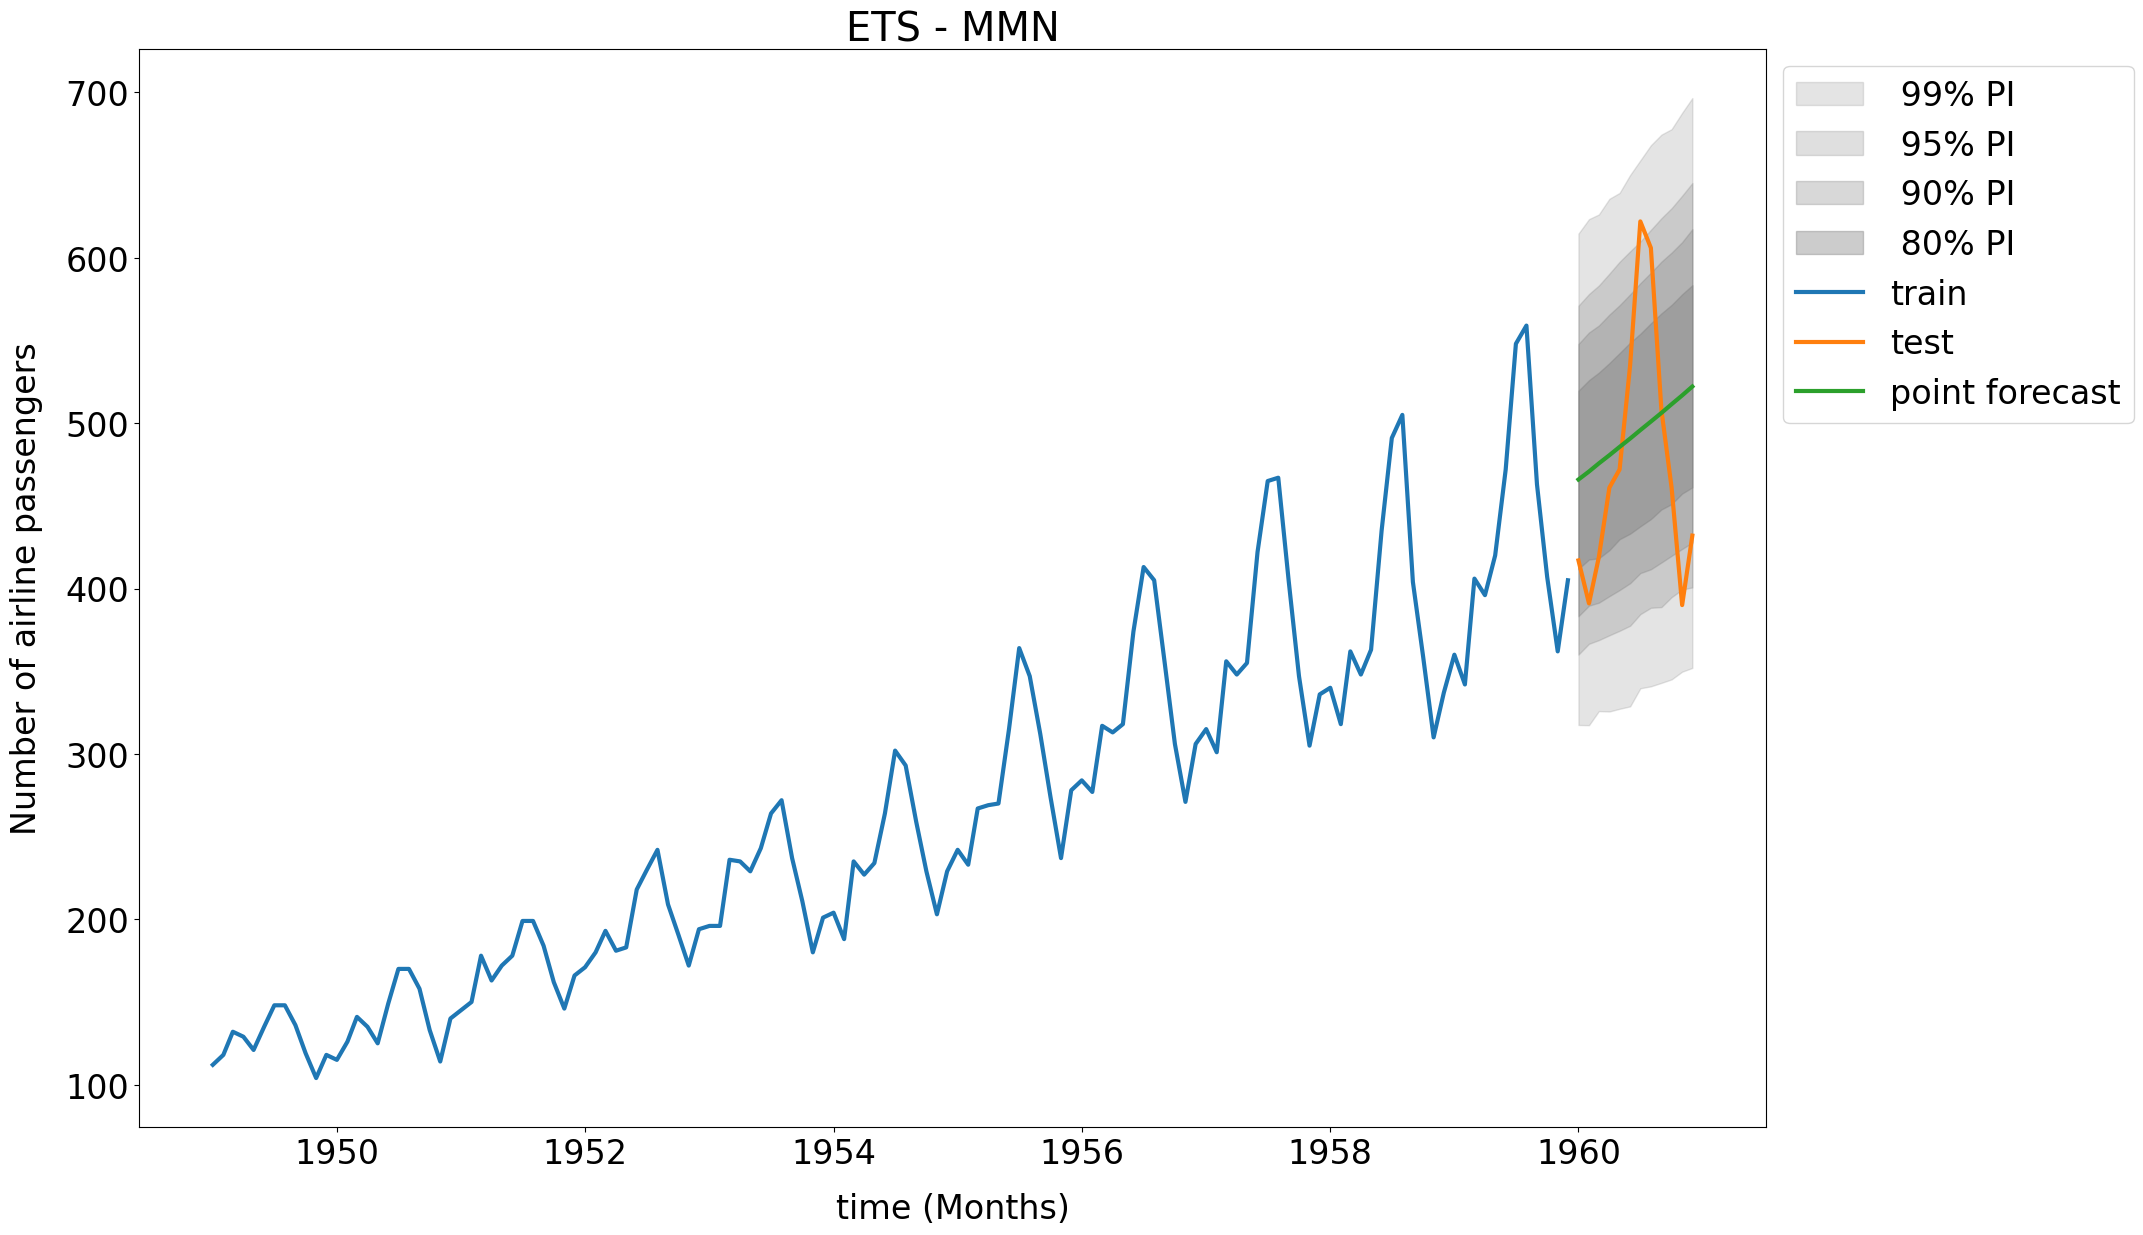

In [33]:
y_train = y.iloc[:-12]
y_test = y.iloc[-12:]

ets_mam = ETSModel(
    endog=y_train, 
    seasonal_periods=12, 
    error="mul",
    trend="add",
    seasonal="mul",
)
results_mam = ets_mam.fit(disp=0)
sims_mam = results_mam.simulate(
    nsimulations=12, 
    repetitions=10000, 
    anchor="end",
    random_state=42
)
point_pred_mam = results_mam.forecast(12)
plot_prediction_intervals_from_simulations(
    y_train, 
    sims_mam, 
    [0.99, 0.95, 0.9, 0.8],
    y_test=y_test,
    point_pred=point_pred_mam
)
plt.title("ETS - MAM")
plt.show()

ets_mmn = ETSModel(
    endog=y_train, 
    seasonal_periods=12, 
    error="mul", 
    trend="mul",
    seasonal=None
)
results_mmn = ets_mmn.fit(disp=0)
sims_mmn = results_mmn.simulate(
    nsimulations=12, 
    repetitions=10000, 
    anchor="end",
    random_state=42
)
point_pred_mmn = results_mmn.forecast(12)
plot_prediction_intervals_from_simulations(
    y_train, 
    sims_mmn, 
    [0.99, 0.95, 0.9, 0.8],
    y_test=y_test,
    point_pred=point_pred_mmn,
)
plt.title("ETS - MMN")
plt.show()

In [34]:
mae_mam = np.mean(np.abs(point_pred_mam - y_test))
mae_mmn = np.mean(np.abs(point_pred_mmn - y_test))

mean_crps_mam_point = np.mean(
    sample_crps(
        actuals=y_test.to_numpy(),
        samples=point_pred_mam.to_numpy().reshape(-1, 1),
        dx=0.1
    )
)

mean_crps_mmn_point = np.mean(
    sample_crps(
        actuals=y_test.to_numpy(),
        samples=point_pred_mmn.to_numpy().reshape(-1, 1),
        dx=0.1
    )
)

mean_crps_mam = np.mean(
    sample_crps(
        actuals=y_test.to_numpy(),
        samples=sims_mam.to_numpy(),
        dx=0.1
    )
)

mean_crps_mmn = np.mean(
    sample_crps(
        actuals=y_test.to_numpy(),
        samples=sims_mmn.to_numpy(),
        dx=0.1
    )
)

mean_logs_mam = np.mean(
    sample_log_score(
        actuals=y_test.to_numpy(),
        samples=sims_mam.to_numpy(),
        n_bins=100
    )
)

mean_logs_mmn = np.mean(
    sample_log_score(
        actuals=y_test.to_numpy(),
        samples=sims_mmn.to_numpy(),
        n_bins=100
    )
)

results = {
    "MAE - ETS MMN": mae_mmn,
    "MAE - ETS MAM": mae_mam,
    "CRPS - ETS MMN point": mean_crps_mmn_point,
    "CRPS - ETS MAM point": mean_crps_mam_point,
    "CRPS - ETS MMN simulations": mean_crps_mmn,
    "CRPS - ETS MAM simulations": mean_crps_mam,
    "LogS - ETS MMN point": None,
    "LogS - ETS MAM point": None,
    "LogS - ETS MMN simulations": mean_logs_mmn,
    "LogS - ETS MAM simulations": mean_logs_mam
}

pprint(results)

{'CRPS - ETS MAM point': np.float64(20.102879762249632),
 'CRPS - ETS MAM simulations': np.float64(15.66087492721815),
 'CRPS - ETS MMN point': np.float64(63.6411126266554),
 'CRPS - ETS MMN simulations': np.float64(43.78842489034563),
 'LogS - ETS MAM point': None,
 'LogS - ETS MAM simulations': np.float64(4.829049251550649),
 'LogS - ETS MMN point': None,
 'LogS - ETS MMN simulations': np.float64(5.731177453659331),
 'MAE - ETS MAM': np.float64(20.12705499050944),
 'MAE - ETS MMN': np.float64(63.61349174275597)}


/var/folders/rz/q8bv6kt16qn0jp923jhqp58h0000gn/T/ipykernel_65823/2000424417.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  crps_vector = np.trapz(
